In [22]:
import os
import csv

# Directory containing the files
directory = "namesbystate"

# Dictionary to store the data
data = {}

# List all files in the directory
files = os.listdir(directory)

# Filter out files that match the pattern "STATE.*.txt"
state_files = [f for f in files if f.startswith("STATE")]

# Read each state file
for state_file in state_files:
    state_abbr = state_file.split('.')[1]  # Extract state abbreviation from the filename
    
    # Initialize the state dictionary if not already present
    if state_abbr not in data:
        data[state_abbr] = {}
    
    with open(os.path.join(directory, state_file), 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            year = int(row[2])
            name_gender_key = f"{row[3]}_{row[1]}"
            
            # Initialize the year dictionary if not already present
            if year not in data[state_abbr]:
                data[state_abbr][year] = {}
            
            data[state_abbr][year][name_gender_key] = int(row[4])
# print(data["AZ"][1910]["Mary_F"])


In [23]:
from gensim import corpora, models
from gensim.models import TfidfModel

# Extract 2022 data
documents = []
for state, years in data.items():
    for y in range(2022, 2023, 5):
        if y in years:
            names = []
            for name, count in years[y].items():
                names.extend([name] * count)
            documents.append(names)


# Create a dictionary from the data
dictionary = corpora.Dictionary(documents)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]

In [9]:
from gensim import corpora
from collections import Counter

# Select the year of interest
year_of_interest = 2022

# Initialize the Counter for names
name_counter = Counter()

# Extract data for the specified year
for state, years in data.items():
    if year_of_interest in years:
        for name, count in years[year_of_interest].items():
            name_counter[name] += count  # Count the names

# Determine the top X most frequent names to remove
X = 0  # Set X as needed
names_to_remove = set(name for name, _ in name_counter.most_common(X))

# Keep the next top Y names in the dictionary
Y = 400  # Set Y as needed
names_to_keep = set(name for name, _ in name_counter.most_common(X + Y)) - names_to_remove

# Process the data for the year of interest, applying filtering and then normalization
common_total = 1000  # Common total for normalization
documents = []

for state, years in data.items():
    if year_of_interest in years:
        # Apply the filtering
        filtered_names = {name: count for name, count in years[year_of_interest].items() if name in names_to_keep}

        # Calculate the total count after filtering
        total_count = sum(filtered_names.values())

        # Calculate the scale factor for normalization
        scale_factor = common_total / total_count if total_count else 0

        # Scale and round the counts
        scaled_names = {name: round(count * scale_factor) for name, count in filtered_names.items()}

        # Create the document for the state
        document = [name for name, scaled_count in scaled_names.items() for _ in range(scaled_count)]
        documents.append(document)

# Create a dictionary from the data
dictionary = corpora.Dictionary(documents)

# Convert the documents to a bag-of-words representation
corpus = [dictionary.doc2bow(document) for document in documents]


In [32]:
from gensim import models
# Run LDA
# alpha is document topic distribution
# eta is topic word distribution
num_topics = 10  # You can adjust this
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=num_topics) #alpha=0.1, eta=0.1)

# Print the topics
for topic in lda.print_topics():
    print(topic)


(0, '0.007*"Liam_M" + 0.006*"Noah_M" + 0.006*"Olivia_F" + 0.005*"Sophia_F" + 0.005*"Charlotte_F" + 0.005*"Oliver_M" + 0.005*"Lucas_M" + 0.005*"James_M" + 0.005*"Elijah_M" + 0.005*"Isabella_F"')
(1, '0.009*"Liam_M" + 0.007*"Olivia_F" + 0.007*"Noah_M" + 0.006*"Oliver_M" + 0.005*"Amelia_F" + 0.005*"Emma_F" + 0.005*"James_M" + 0.005*"William_M" + 0.004*"Charlotte_F" + 0.004*"Isabella_F"')
(2, '0.006*"Noah_M" + 0.005*"Henry_M" + 0.005*"Elijah_M" + 0.005*"Oliver_M" + 0.005*"Theodore_M" + 0.005*"Isabella_F" + 0.005*"Levi_M" + 0.004*"Emma_F" + 0.004*"Benjamin_M" + 0.004*"Liam_M"')
(3, '0.008*"Noah_M" + 0.007*"Liam_M" + 0.006*"Olivia_F" + 0.006*"Charlotte_F" + 0.005*"Elijah_M" + 0.005*"Emma_F" + 0.005*"Mateo_M" + 0.005*"Sophia_F" + 0.004*"Theodore_M" + 0.004*"Ava_F"')
(4, '0.009*"Noah_M" + 0.006*"Olivia_F" + 0.006*"Oliver_M" + 0.005*"Liam_M" + 0.005*"Isabella_F" + 0.005*"Emma_F" + 0.005*"Lucas_M" + 0.005*"Charlotte_F" + 0.004*"Henry_M" + 0.004*"Amelia_F"')
(5, '0.006*"Emma_F" + 0.006*"Liam_M" +

In [33]:
from gensim import models
import numpy as np

# Assuming lda is your trained LdaModel and dictionary is your Gensim dictionary

num_topics = lda.num_topics  # Number of topics in the model
topic_word_distributions = {topic: dict(lda.show_topic(topic, topn=len(dictionary))) for topic in range(num_topics)}

# Function to find distinctive words for each topic
def find_distinctive_words(topic_word_distributions):
    distinctive_words = {}
    for topic in topic_word_distributions:
        other_topics = set(topic_word_distributions.keys()) - {topic}
        word_scores = {}

        for word, prob in topic_word_distributions[topic].items():
            max_prob_other_topics = np.max([topic_word_distributions[ot].get(word, 0) for ot in other_topics])
            distinctiveness_score = prob - max_prob_other_topics
            word_scores[word] = distinctiveness_score

        # Sort words by distinctiveness score
        distinctive_words[topic] = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)

    return distinctive_words

# Get distinctive words for each topic
distinctive_words_per_topic = find_distinctive_words(topic_word_distributions)

# Print distinctive words for each topic
for topic, words in distinctive_words_per_topic.items():
    print(f"Topic {topic}:")
    for word, score in words[:20]:  # Adjust the number to get more or fewer words
        print(f"  {word}: {score}")
    print("\n")


Topic 0:
  Asher_M: 0.001098370412364602
  Gabriel_M: 0.0006718365475535393
  Madison_F: 0.000436500646173954
  John_M: 0.00039564608596265316
  Christopher_M: 0.0003949489910155535
  Joseph_M: 0.0003648607525974512
  Mason_M: 0.0002786228433251381
  Bennett_M: 0.0002711296547204256
  Roman_M: 0.00021790177561342716
  Anthony_M: 0.00021413643844425678
  Cameron_M: 0.00020675151608884335
  Colton_M: 0.0002054309006780386
  Luka_M: 0.00019728427287191153
  Jeremiah_M: 0.0001844634534791112
  Isaac_M: 0.00018138461746275425
  Enzo_M: 0.0001689790515229106
  Kayden_M: 0.0001579300733283162
  Eleanor_F: 0.00015375064685940742
  Ayla_F: 0.00015127588994801044
  Andres_M: 0.00014425948029384017


Topic 1:
  Olivia_F: 0.0006799916736781597
  Oliver_M: 0.0006432193331420422
  Gael_M: 0.0006335107609629631
  Charles_M: 0.00028482801280915737
  William_M: 0.000246644951403141
  Naomi_F: 0.00023842451628297567
  Luis_M: 0.00020997331012040377
  Ivy_F: 0.0002058773534372449
  Nathan_M: 0.0002026783

In [34]:
states = list(data.keys())

state_topic_distributions = {}

for state, bow in zip(states, corpus):
    state_topic_distributions[state] = lda.get_document_topics(bow, minimum_probability=0)

# Print the topic distribution for each state
for state, distribution in state_topic_distributions.items():
    print(f"State: {state}, Distribution: {distribution}")


State: ID, Distribution: [(0, 0.1595554), (1, 0.03626418), (2, 0.09062962), (3, 0.050308317), (4, 0.064315245), (5, 0.026002731), (6, 0.06214034), (7, 0.2659669), (8, 0.17671521), (9, 0.06810208)]
State: DC, Distribution: [(0, 0.18828884), (1, 0.14244416), (2, 0.05390206), (3, 0.09157101), (4, 0.07538171), (5, 0.06337262), (6, 0.07364064), (7, 0.09491125), (8, 0.14577411), (9, 0.07071359)]
State: KY, Distribution: [(0, 0.10101708), (1, 0.039541975), (2, 0.15285334), (3, 0.0419004), (4, 0.048681423), (5, 0.027691523), (6, 0.033736065), (7, 0.26810125), (8, 0.22347961), (9, 0.062997326)]
State: DE, Distribution: [(0, 0.22101691), (1, 0.11263211), (2, 0.059914794), (3, 0.06251115), (4, 0.0491897), (5, 0.033017427), (6, 0.112971045), (7, 0.06542526), (8, 0.15042806), (9, 0.13289359)]
State: FL, Distribution: [(0, 0.13406512), (1, 0.20508297), (2, 0.022689613), (3, 0.105653614), (4, 0.054084867), (5, 0.13533507), (6, 0.08649764), (7, 0.028191652), (8, 0.10960912), (9, 0.118790336)]
State: P

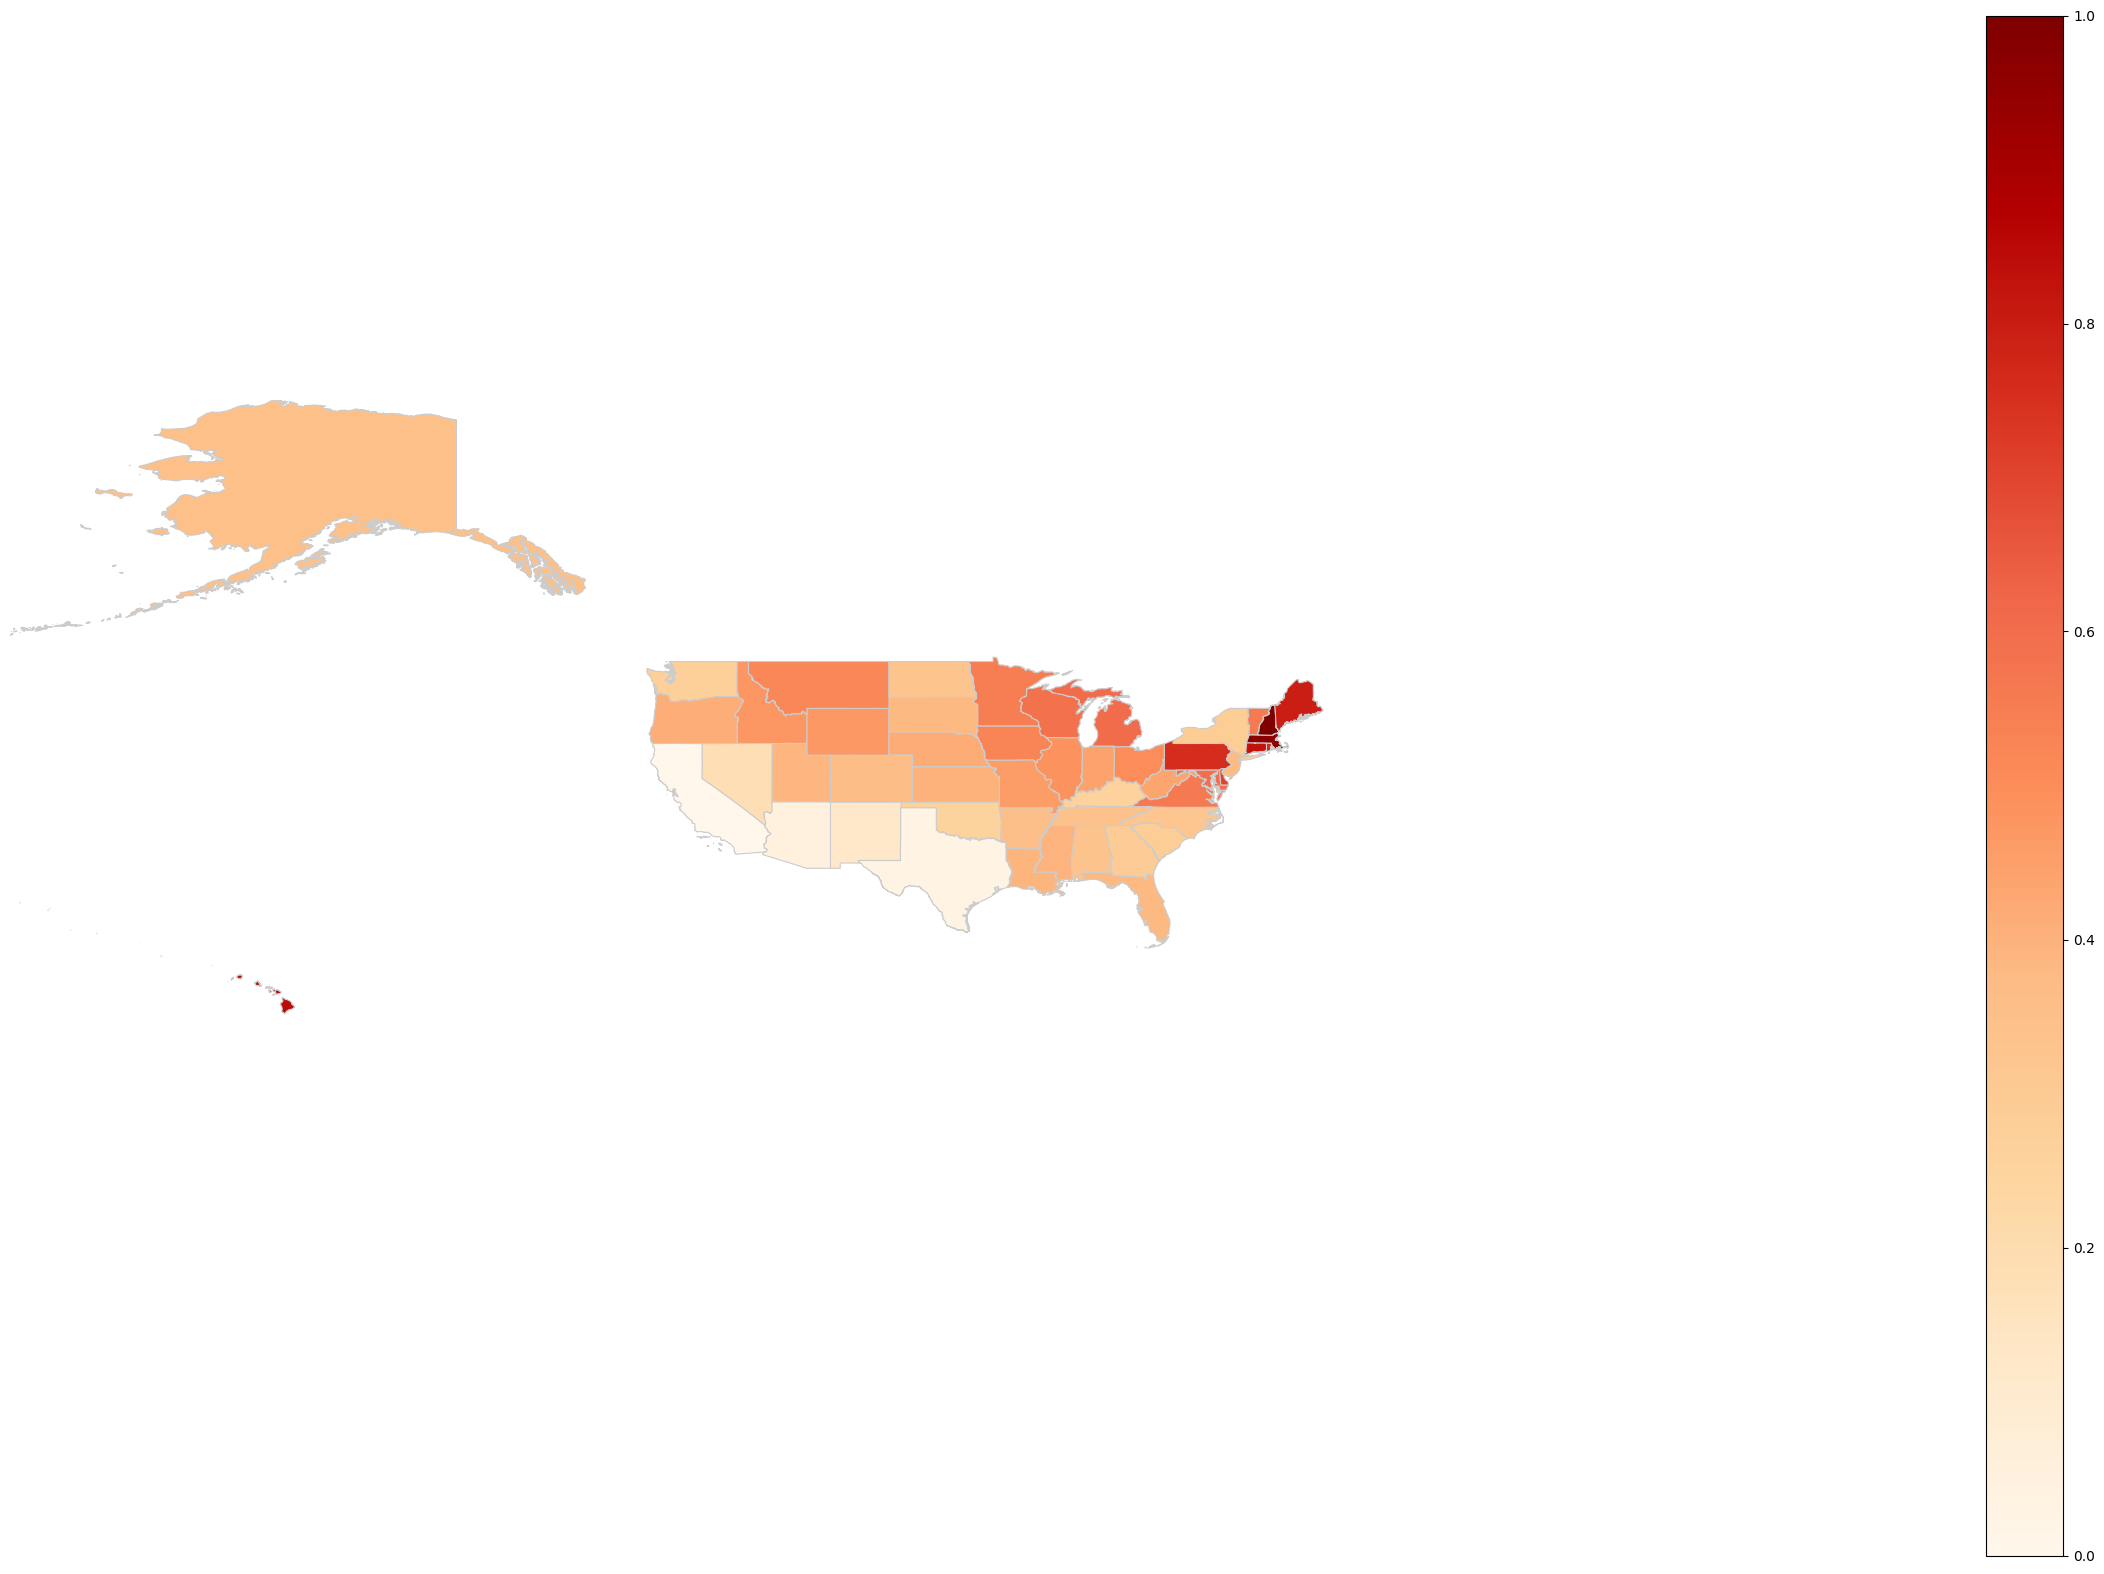

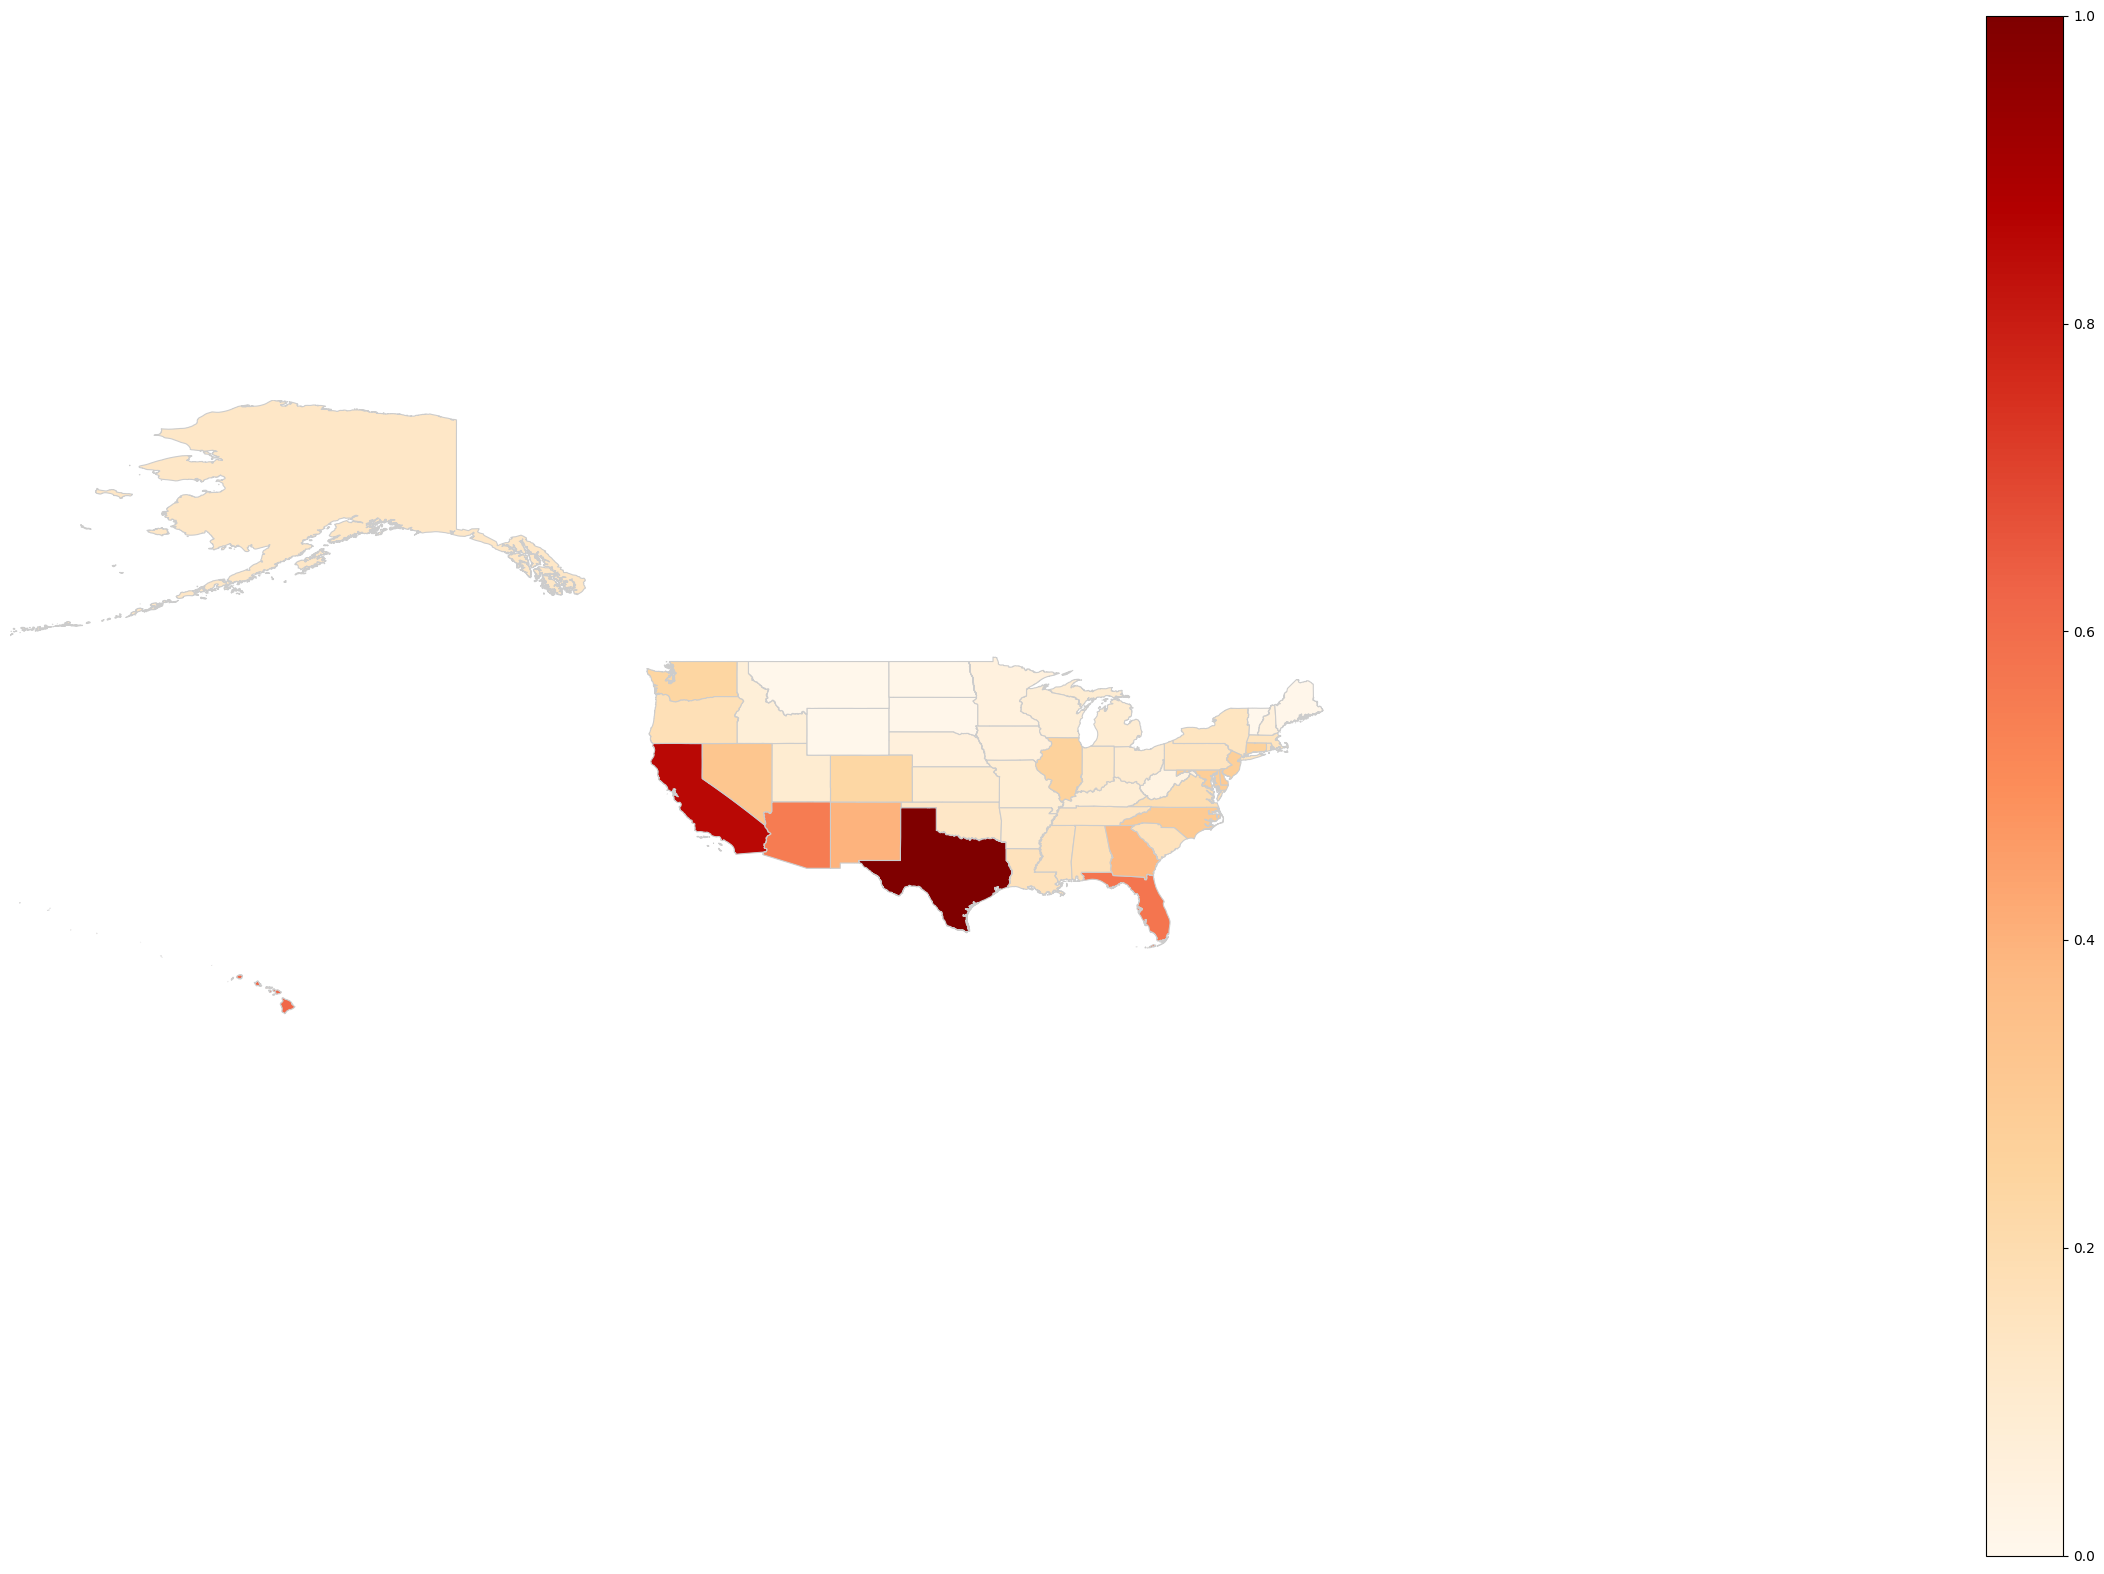

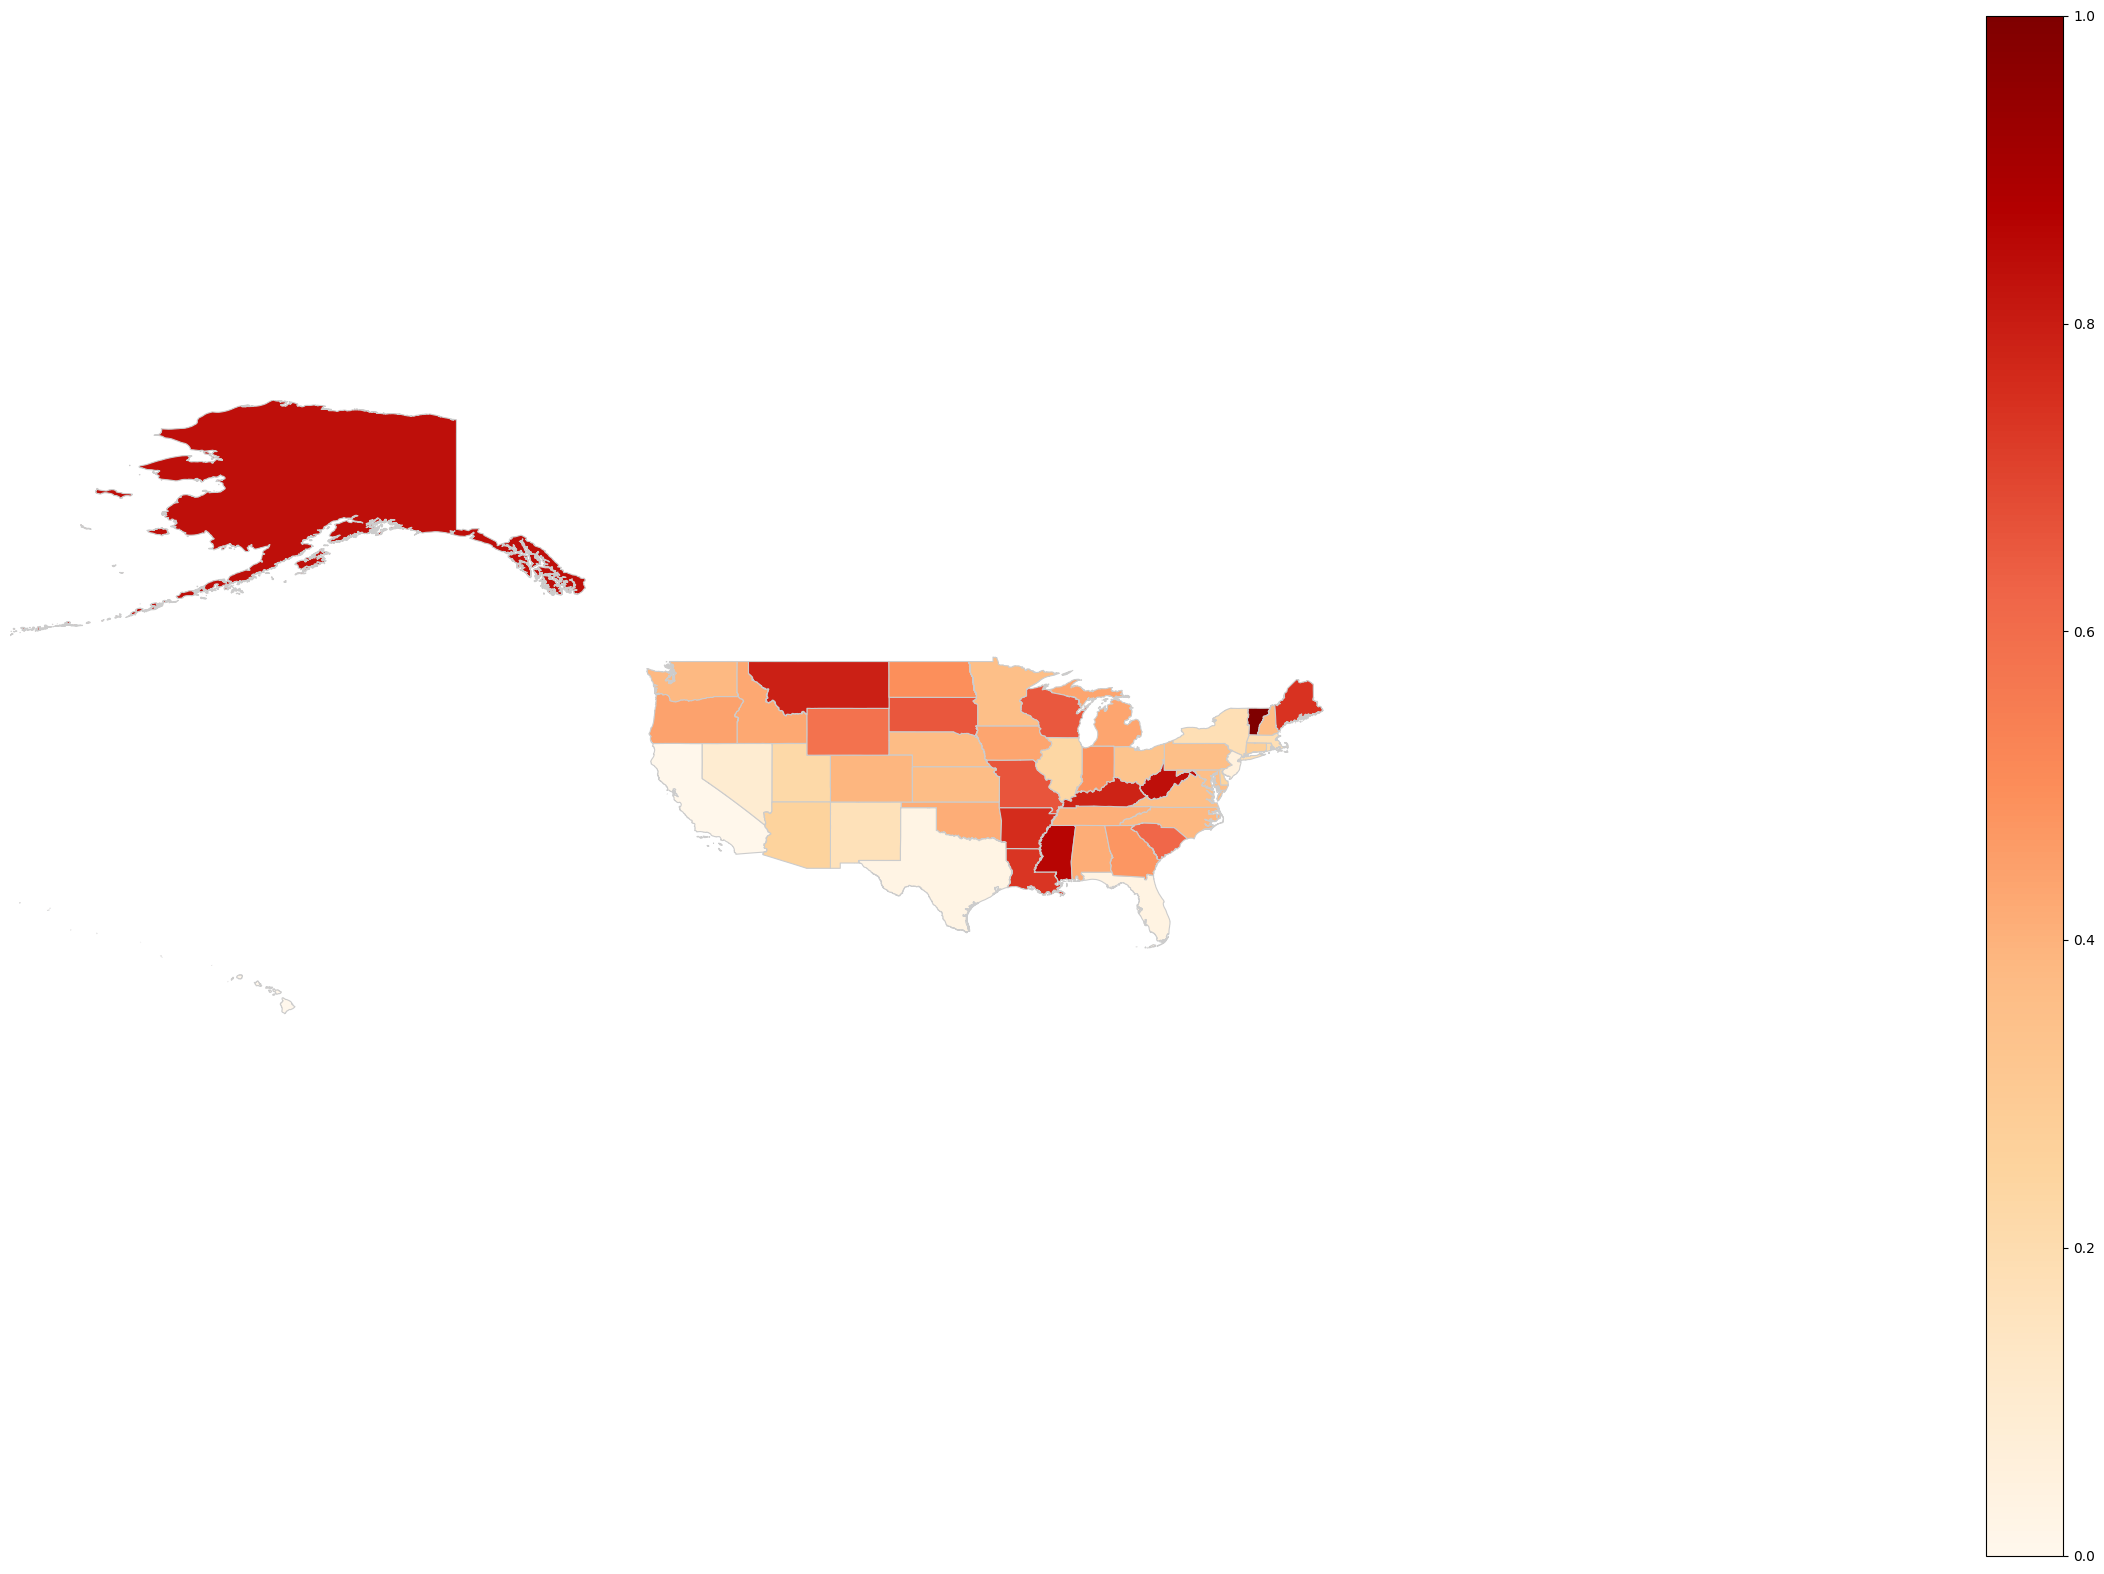

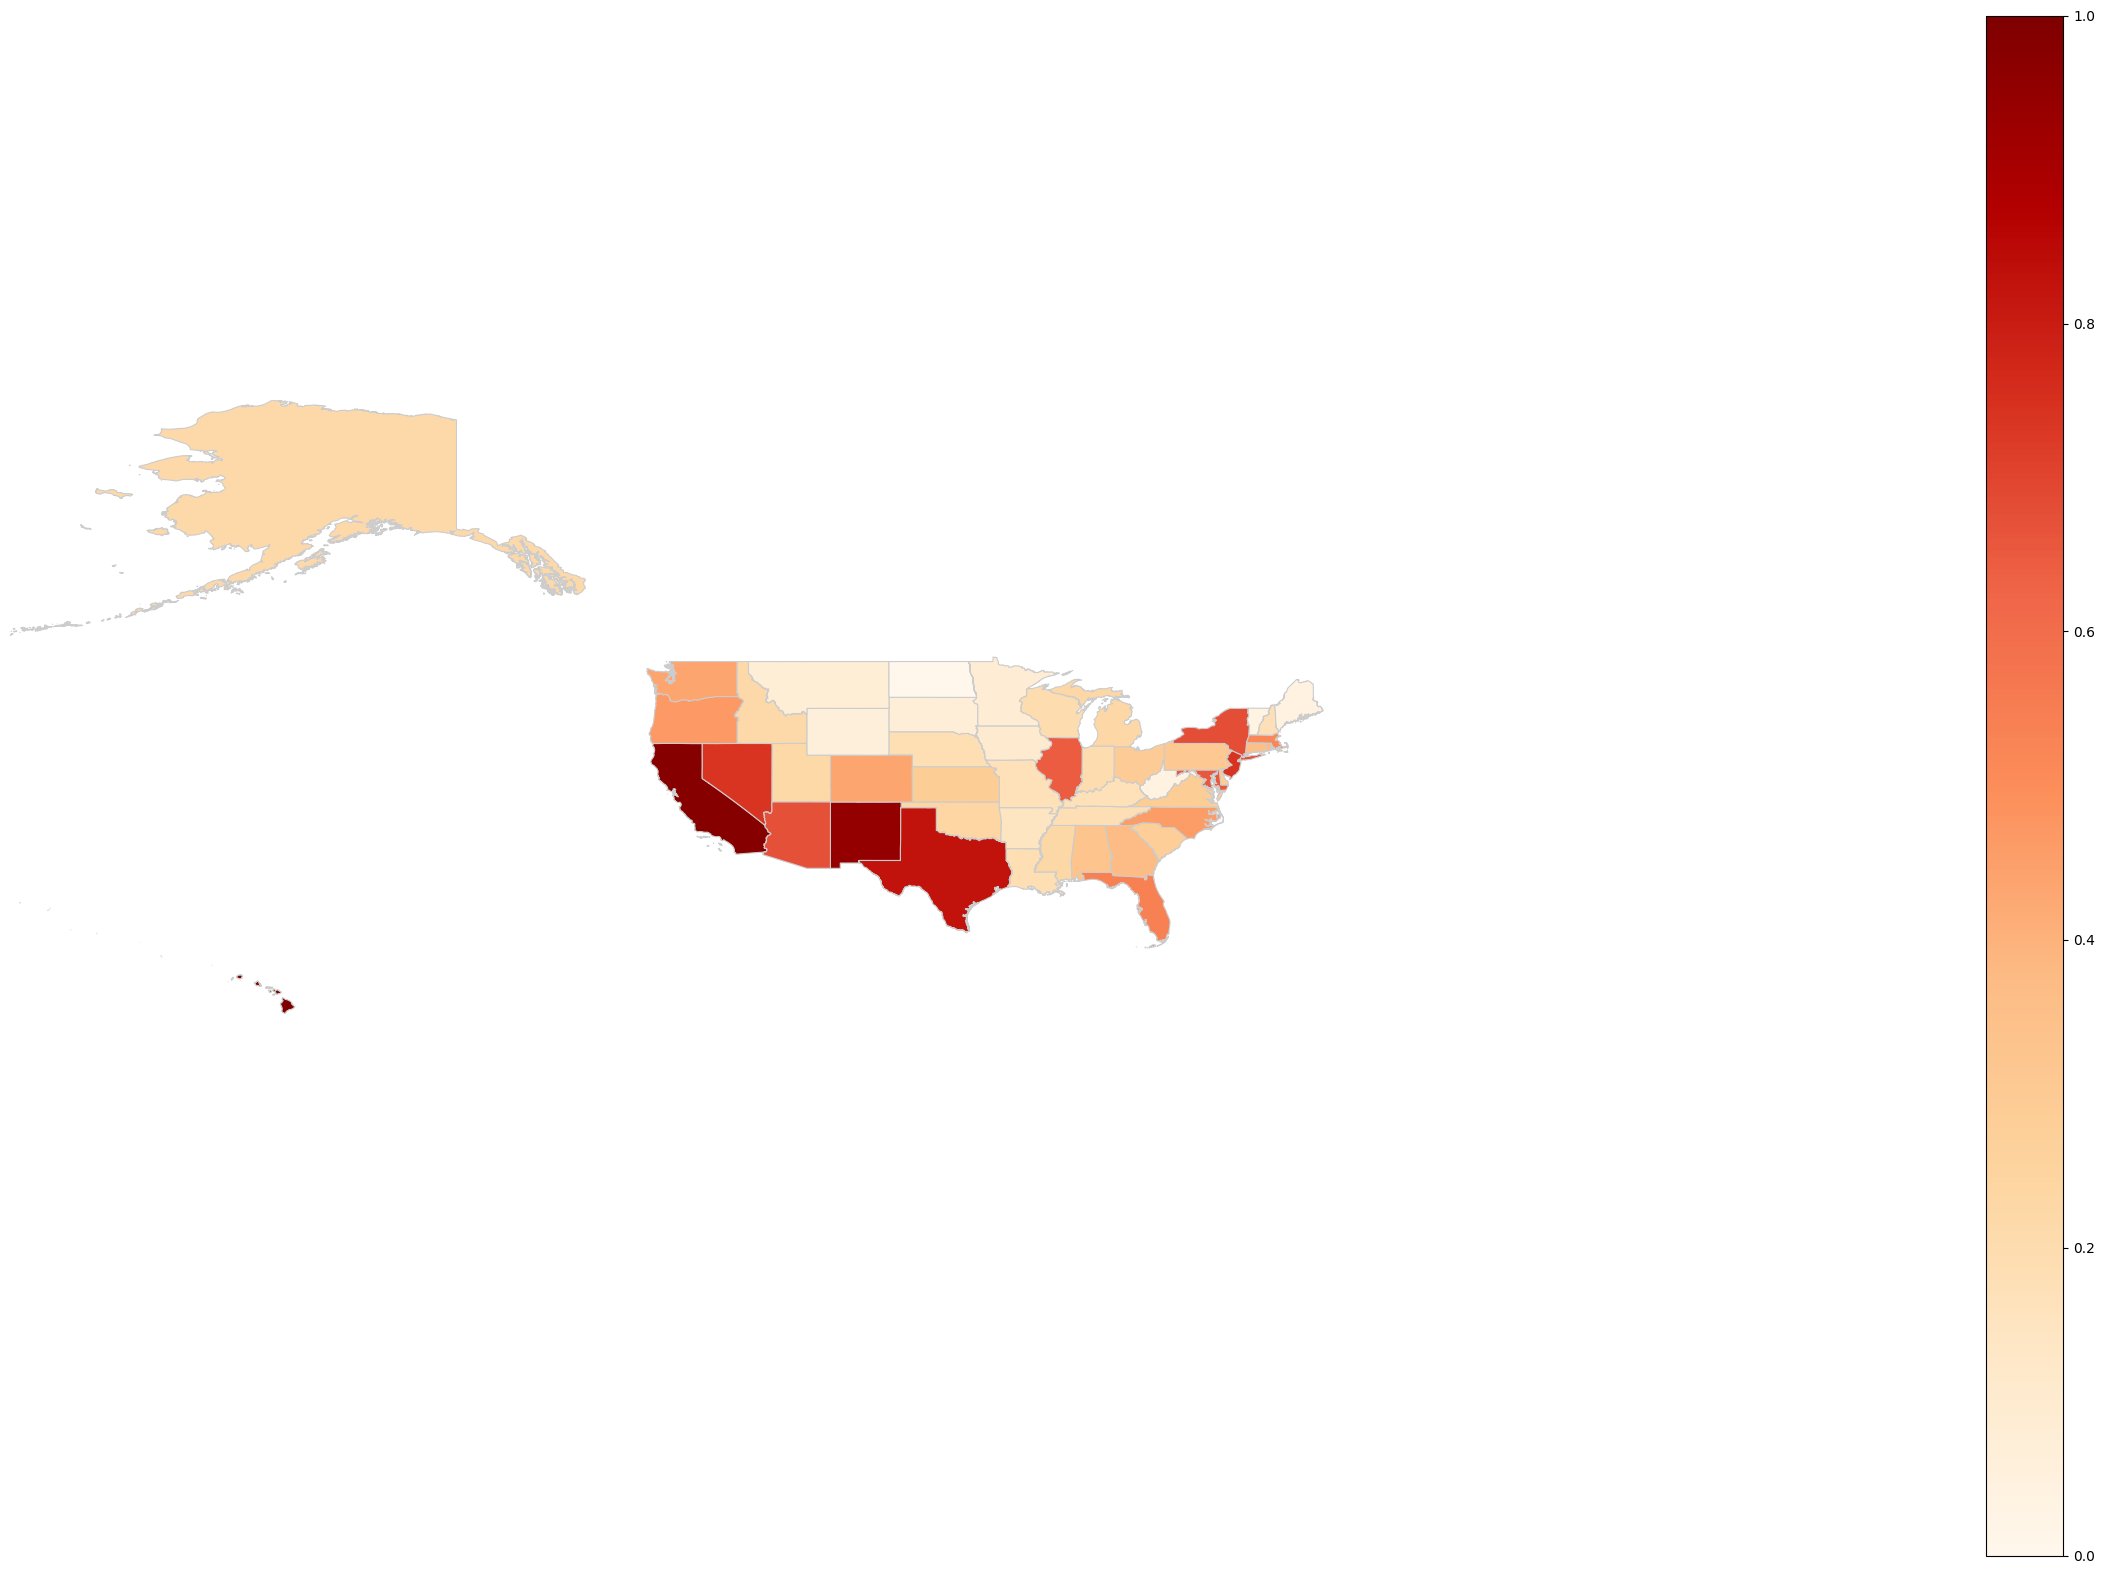

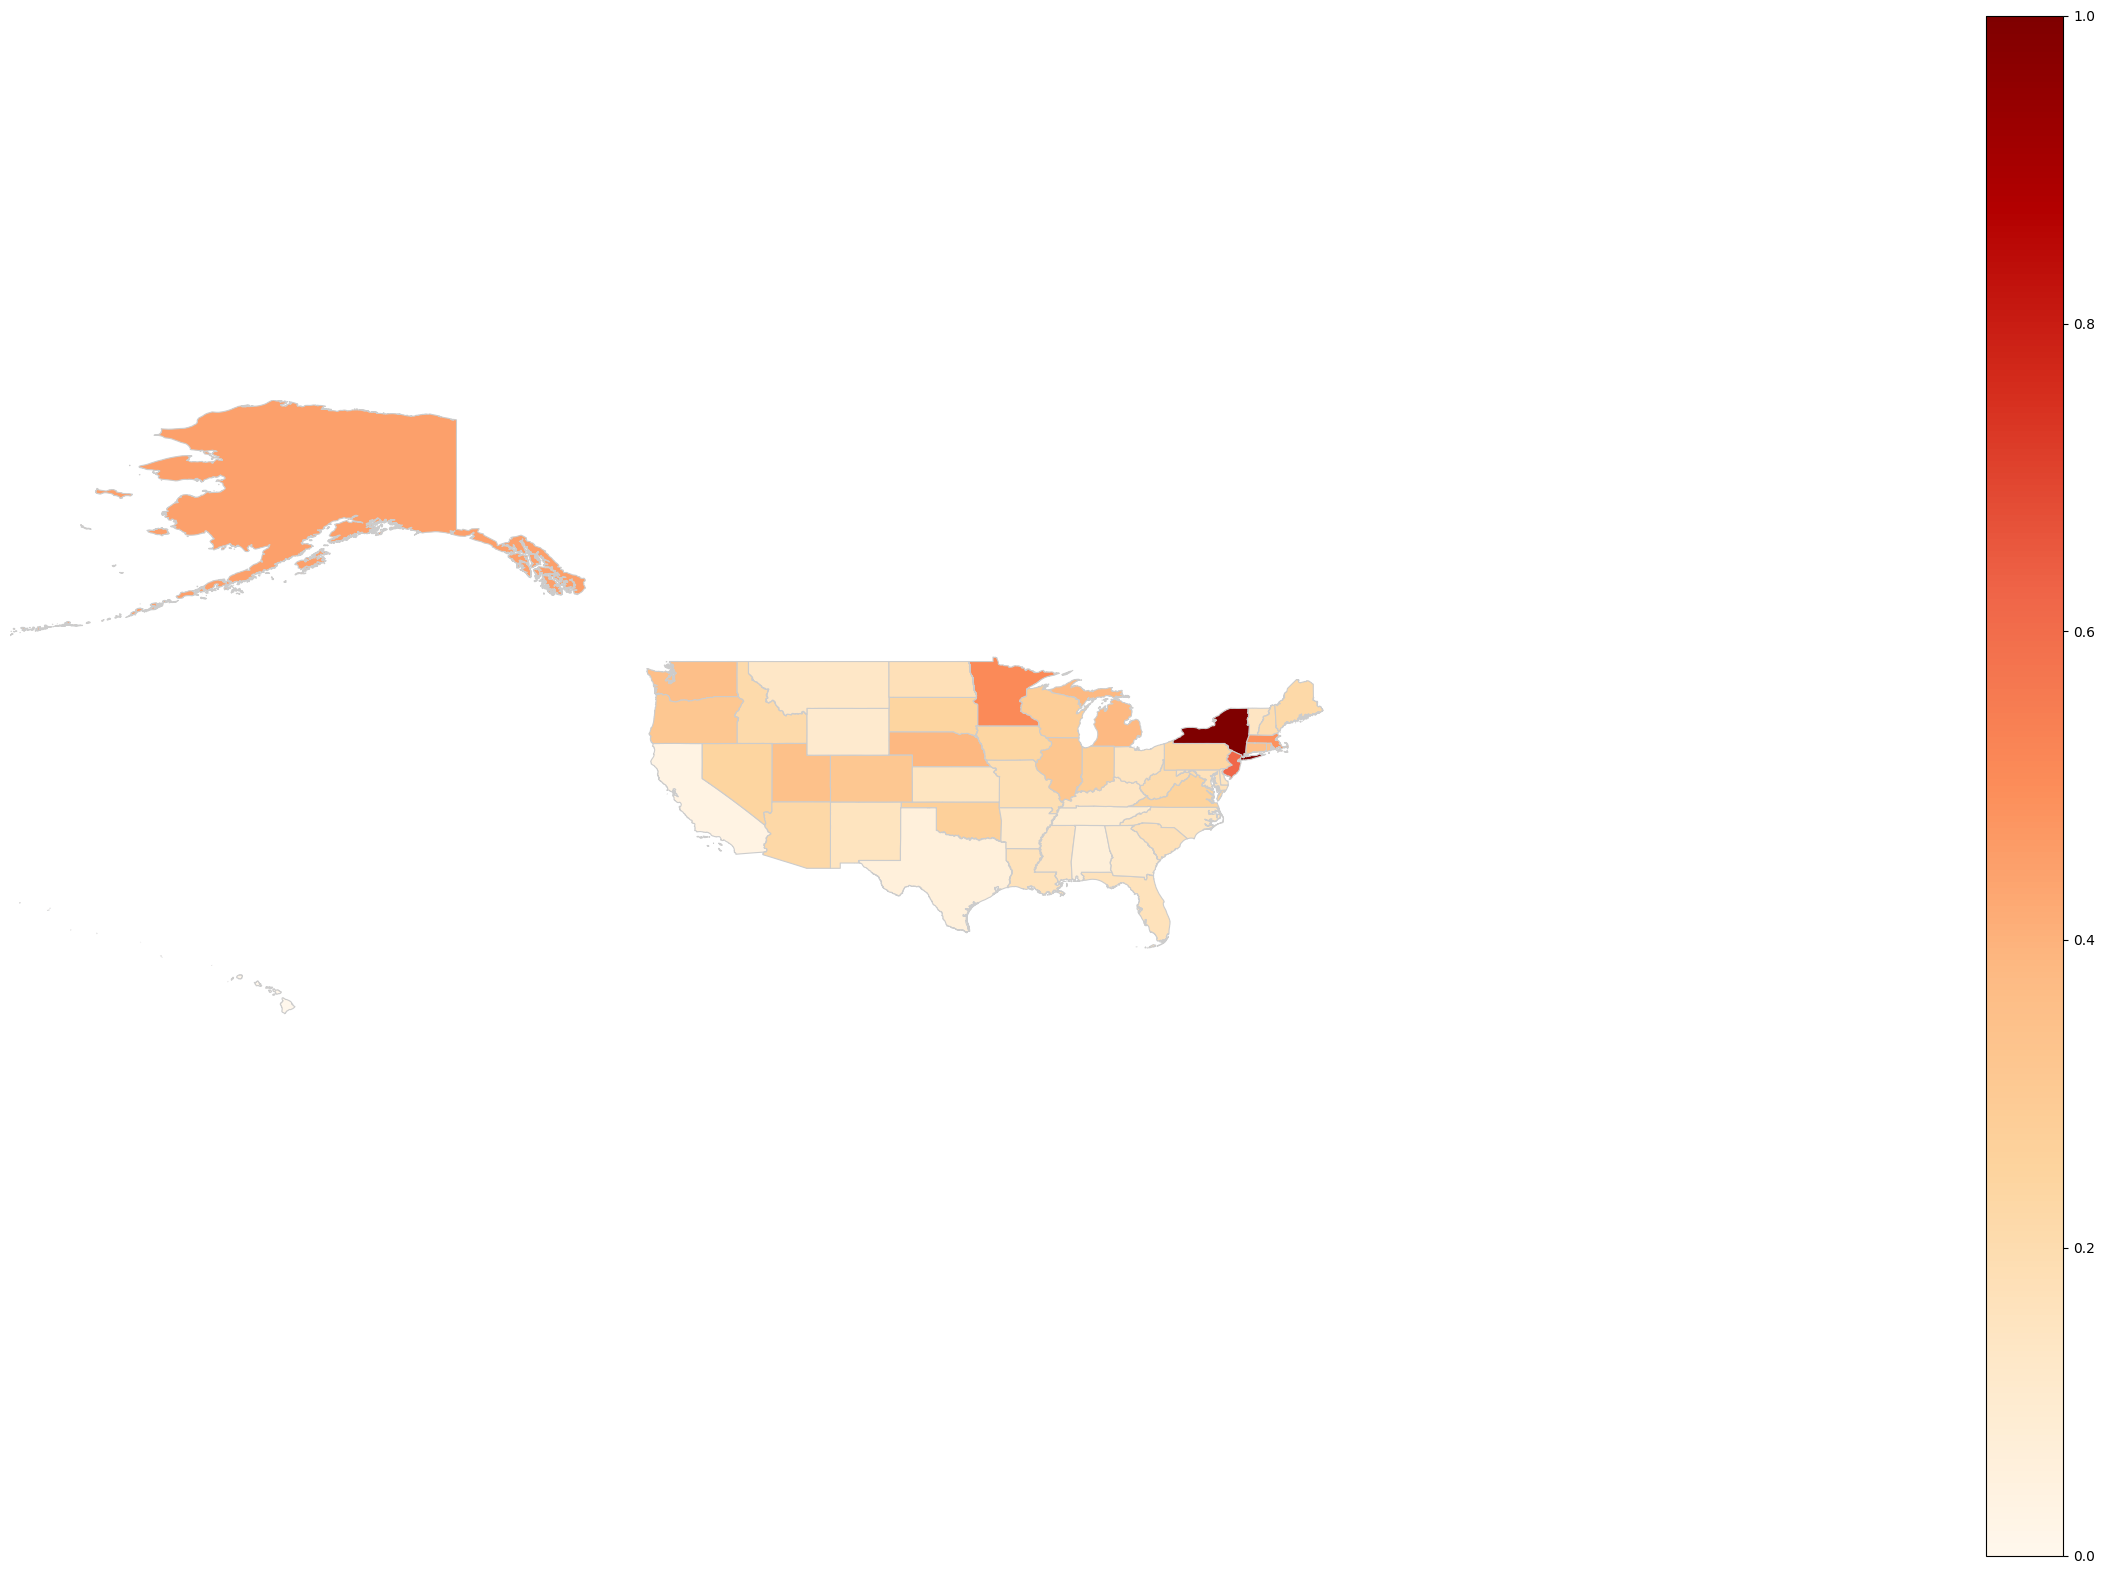

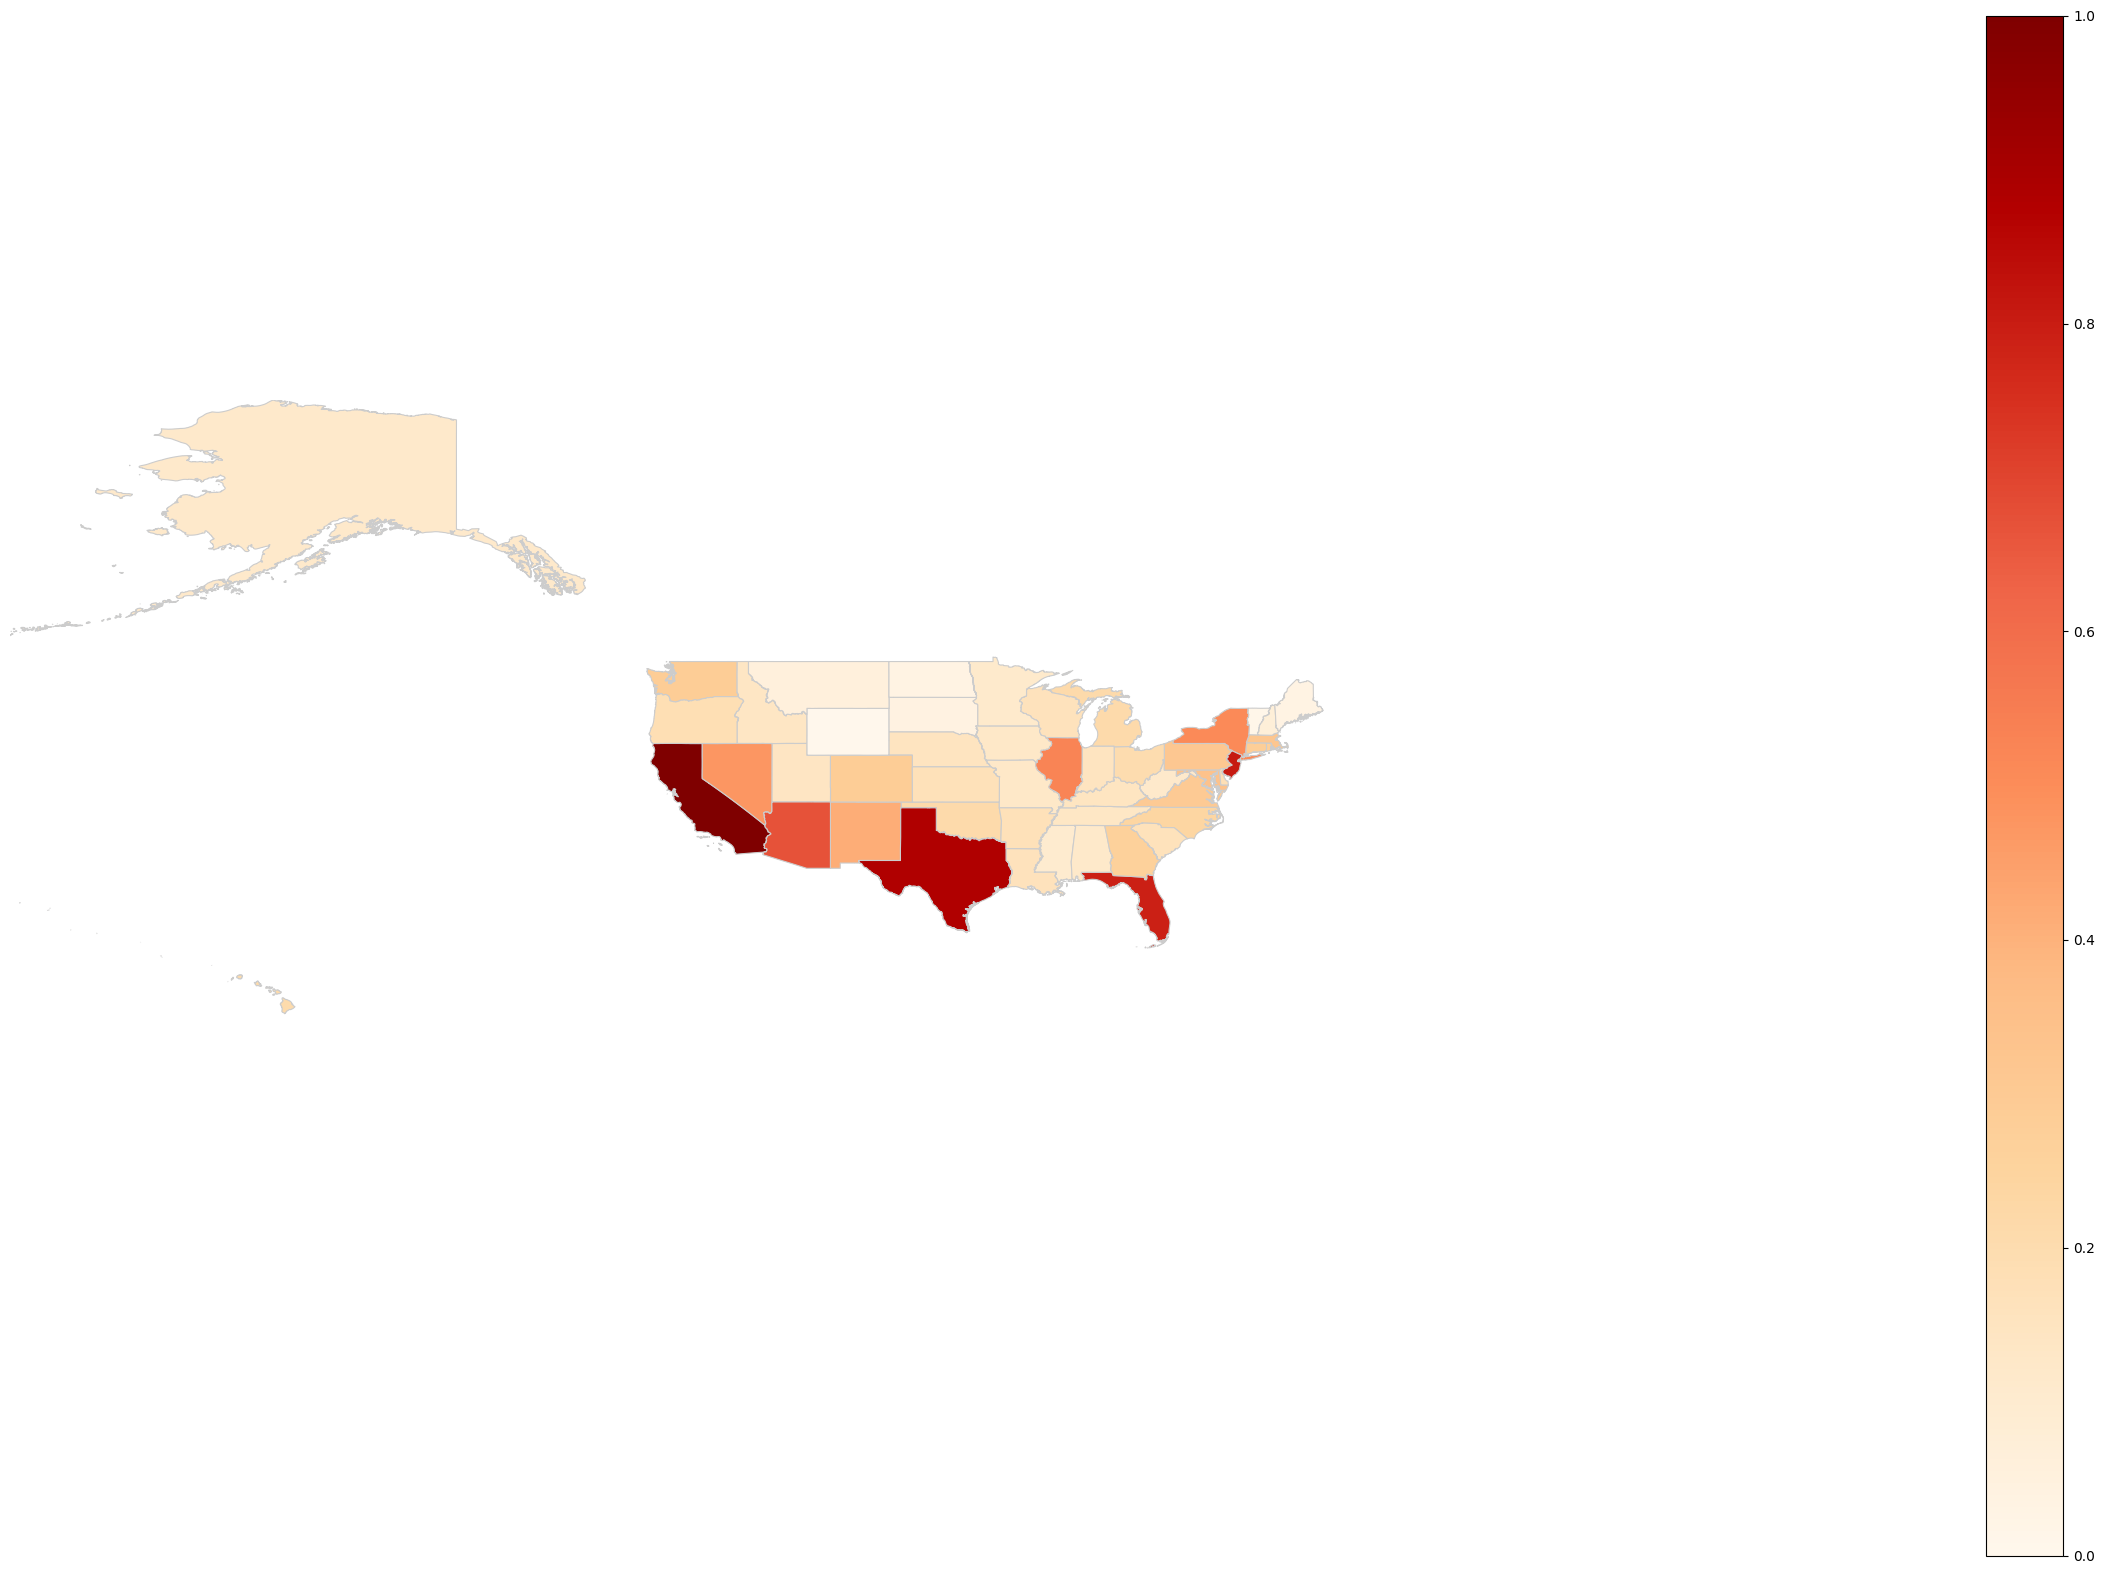

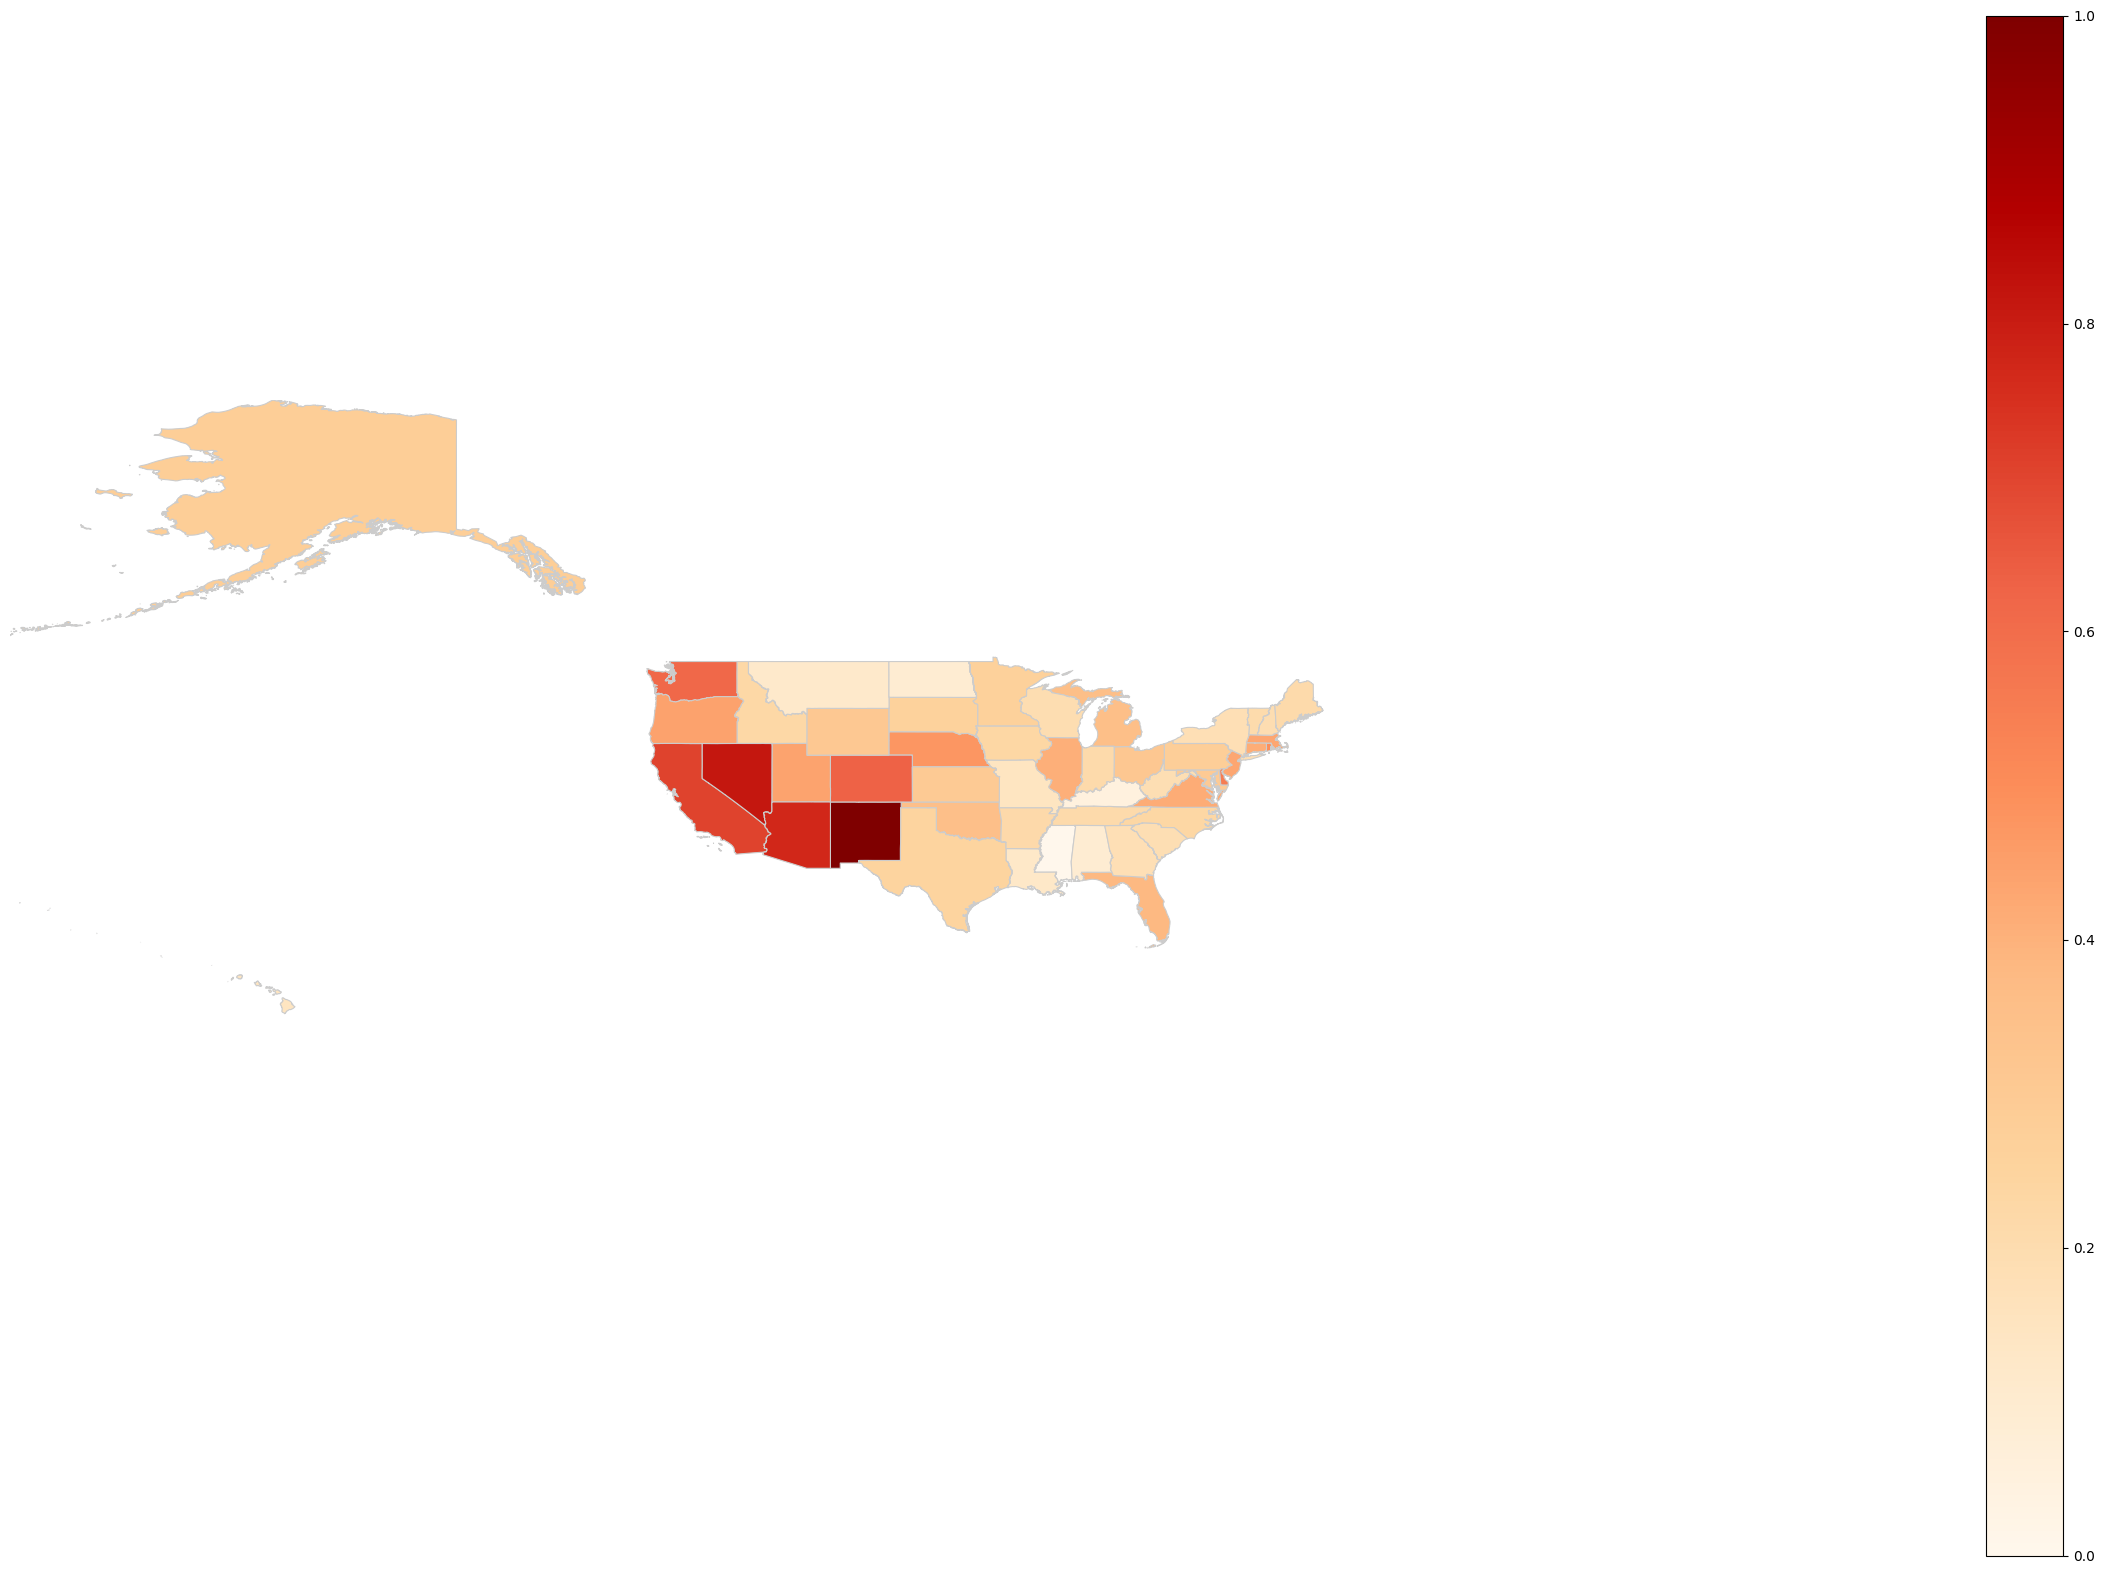

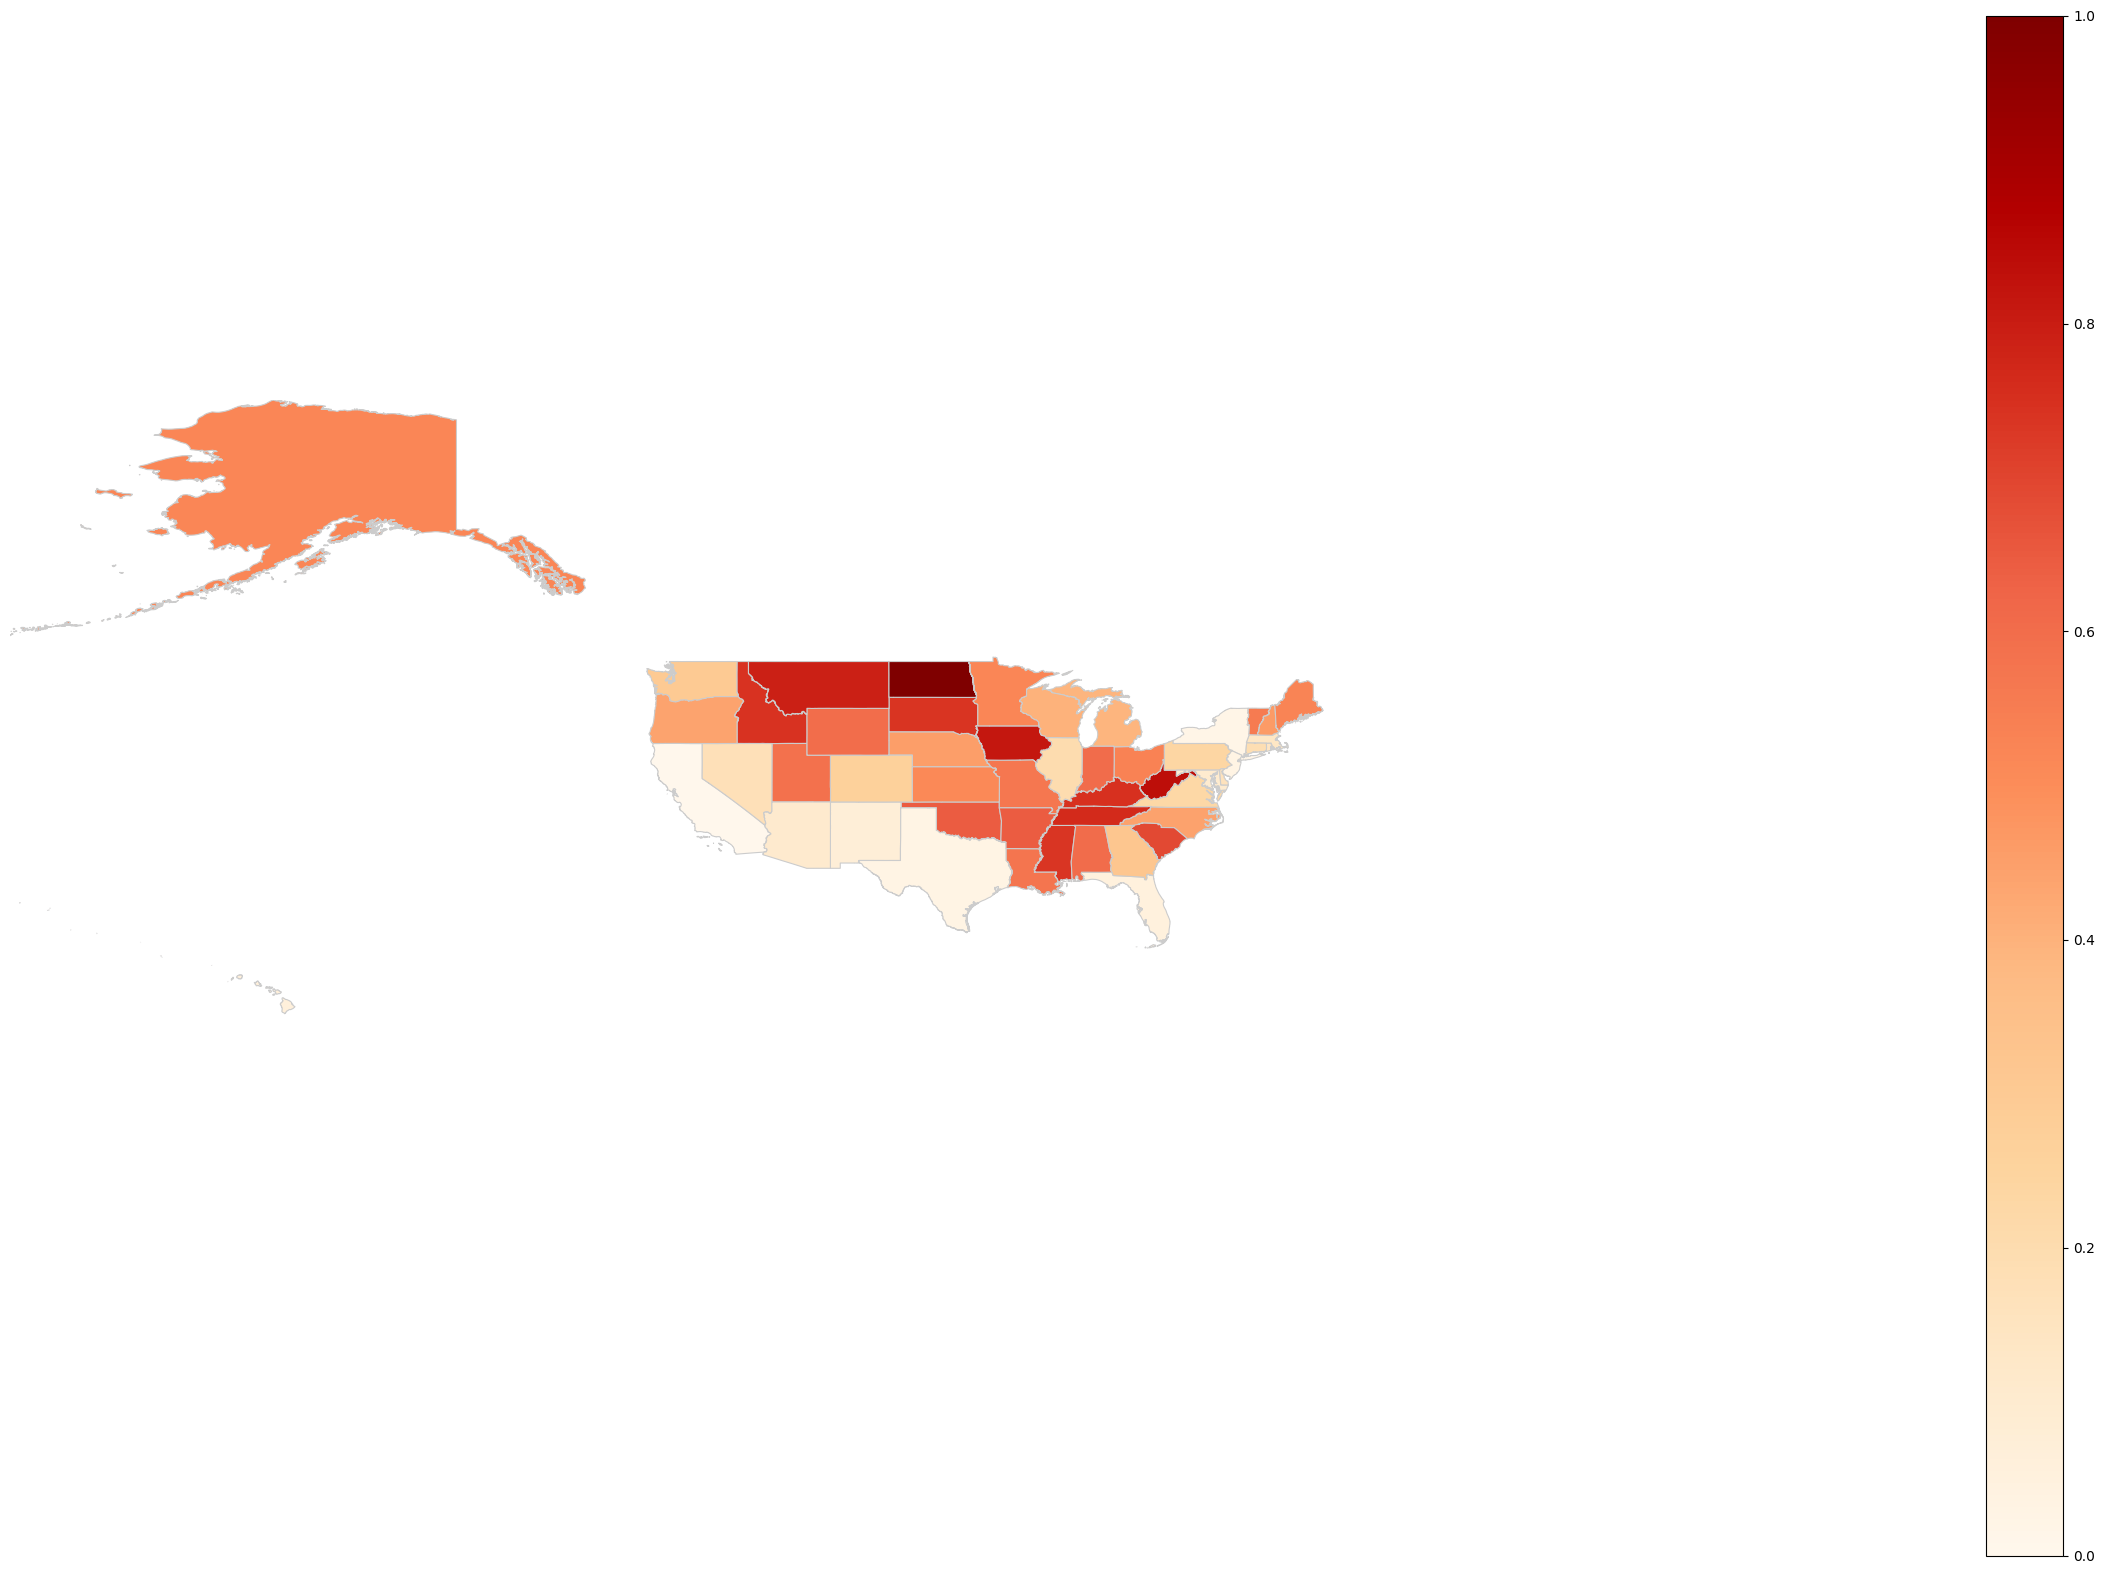

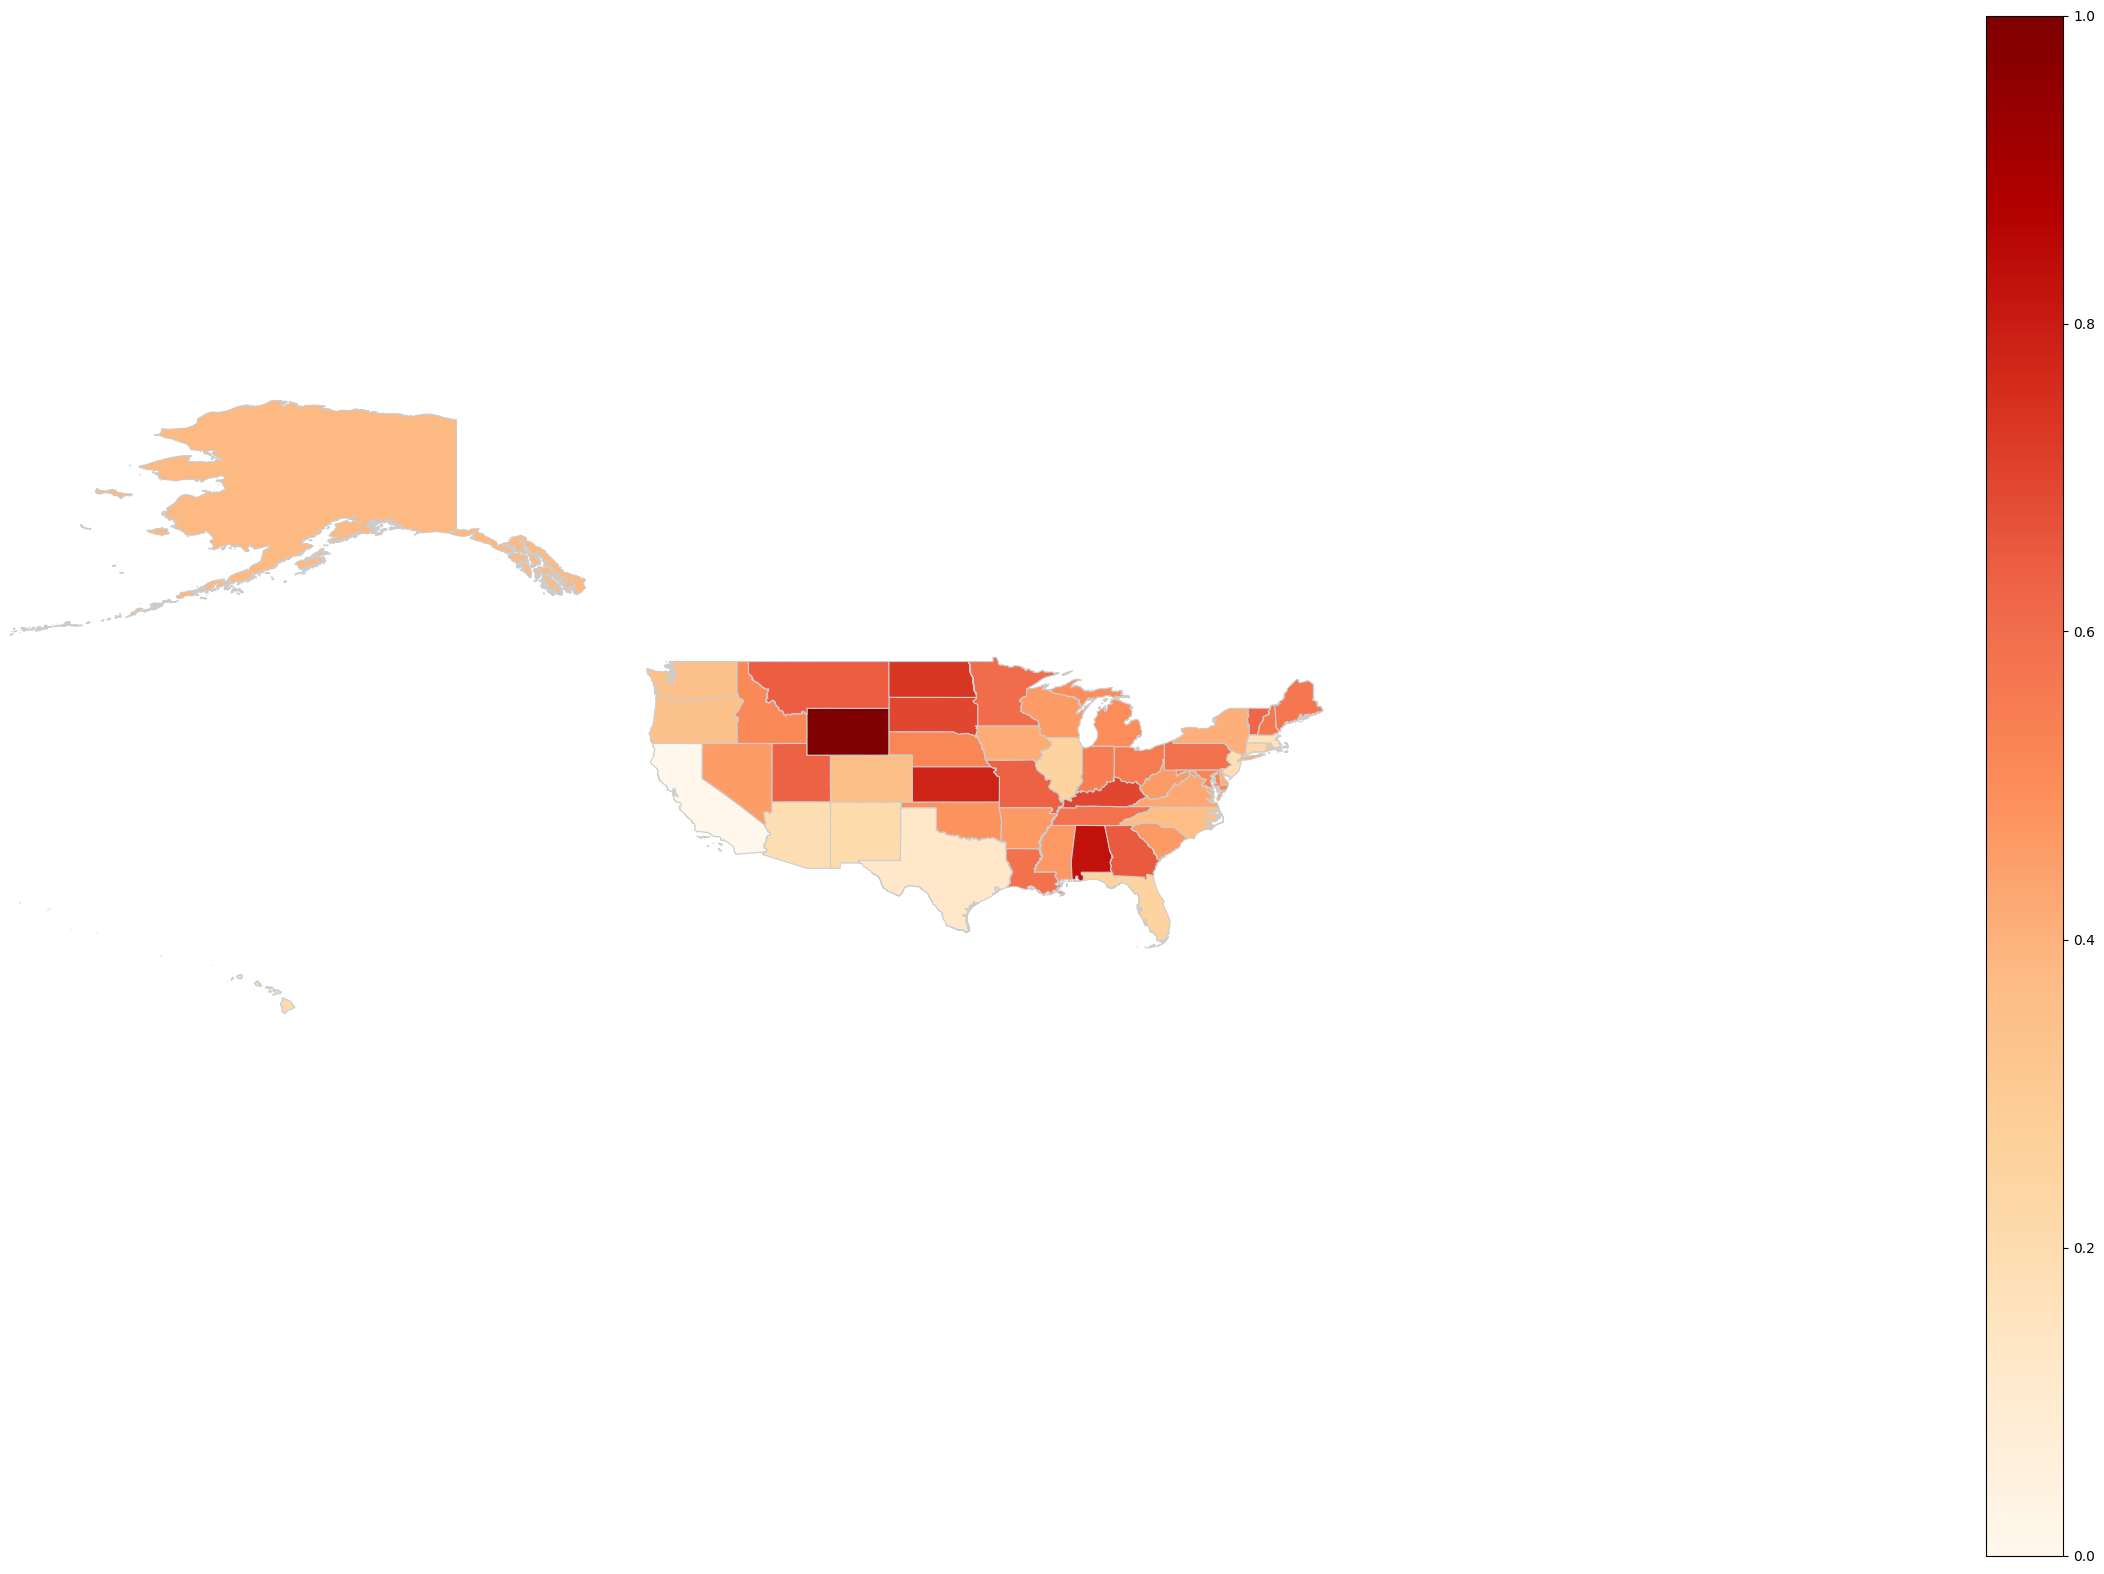

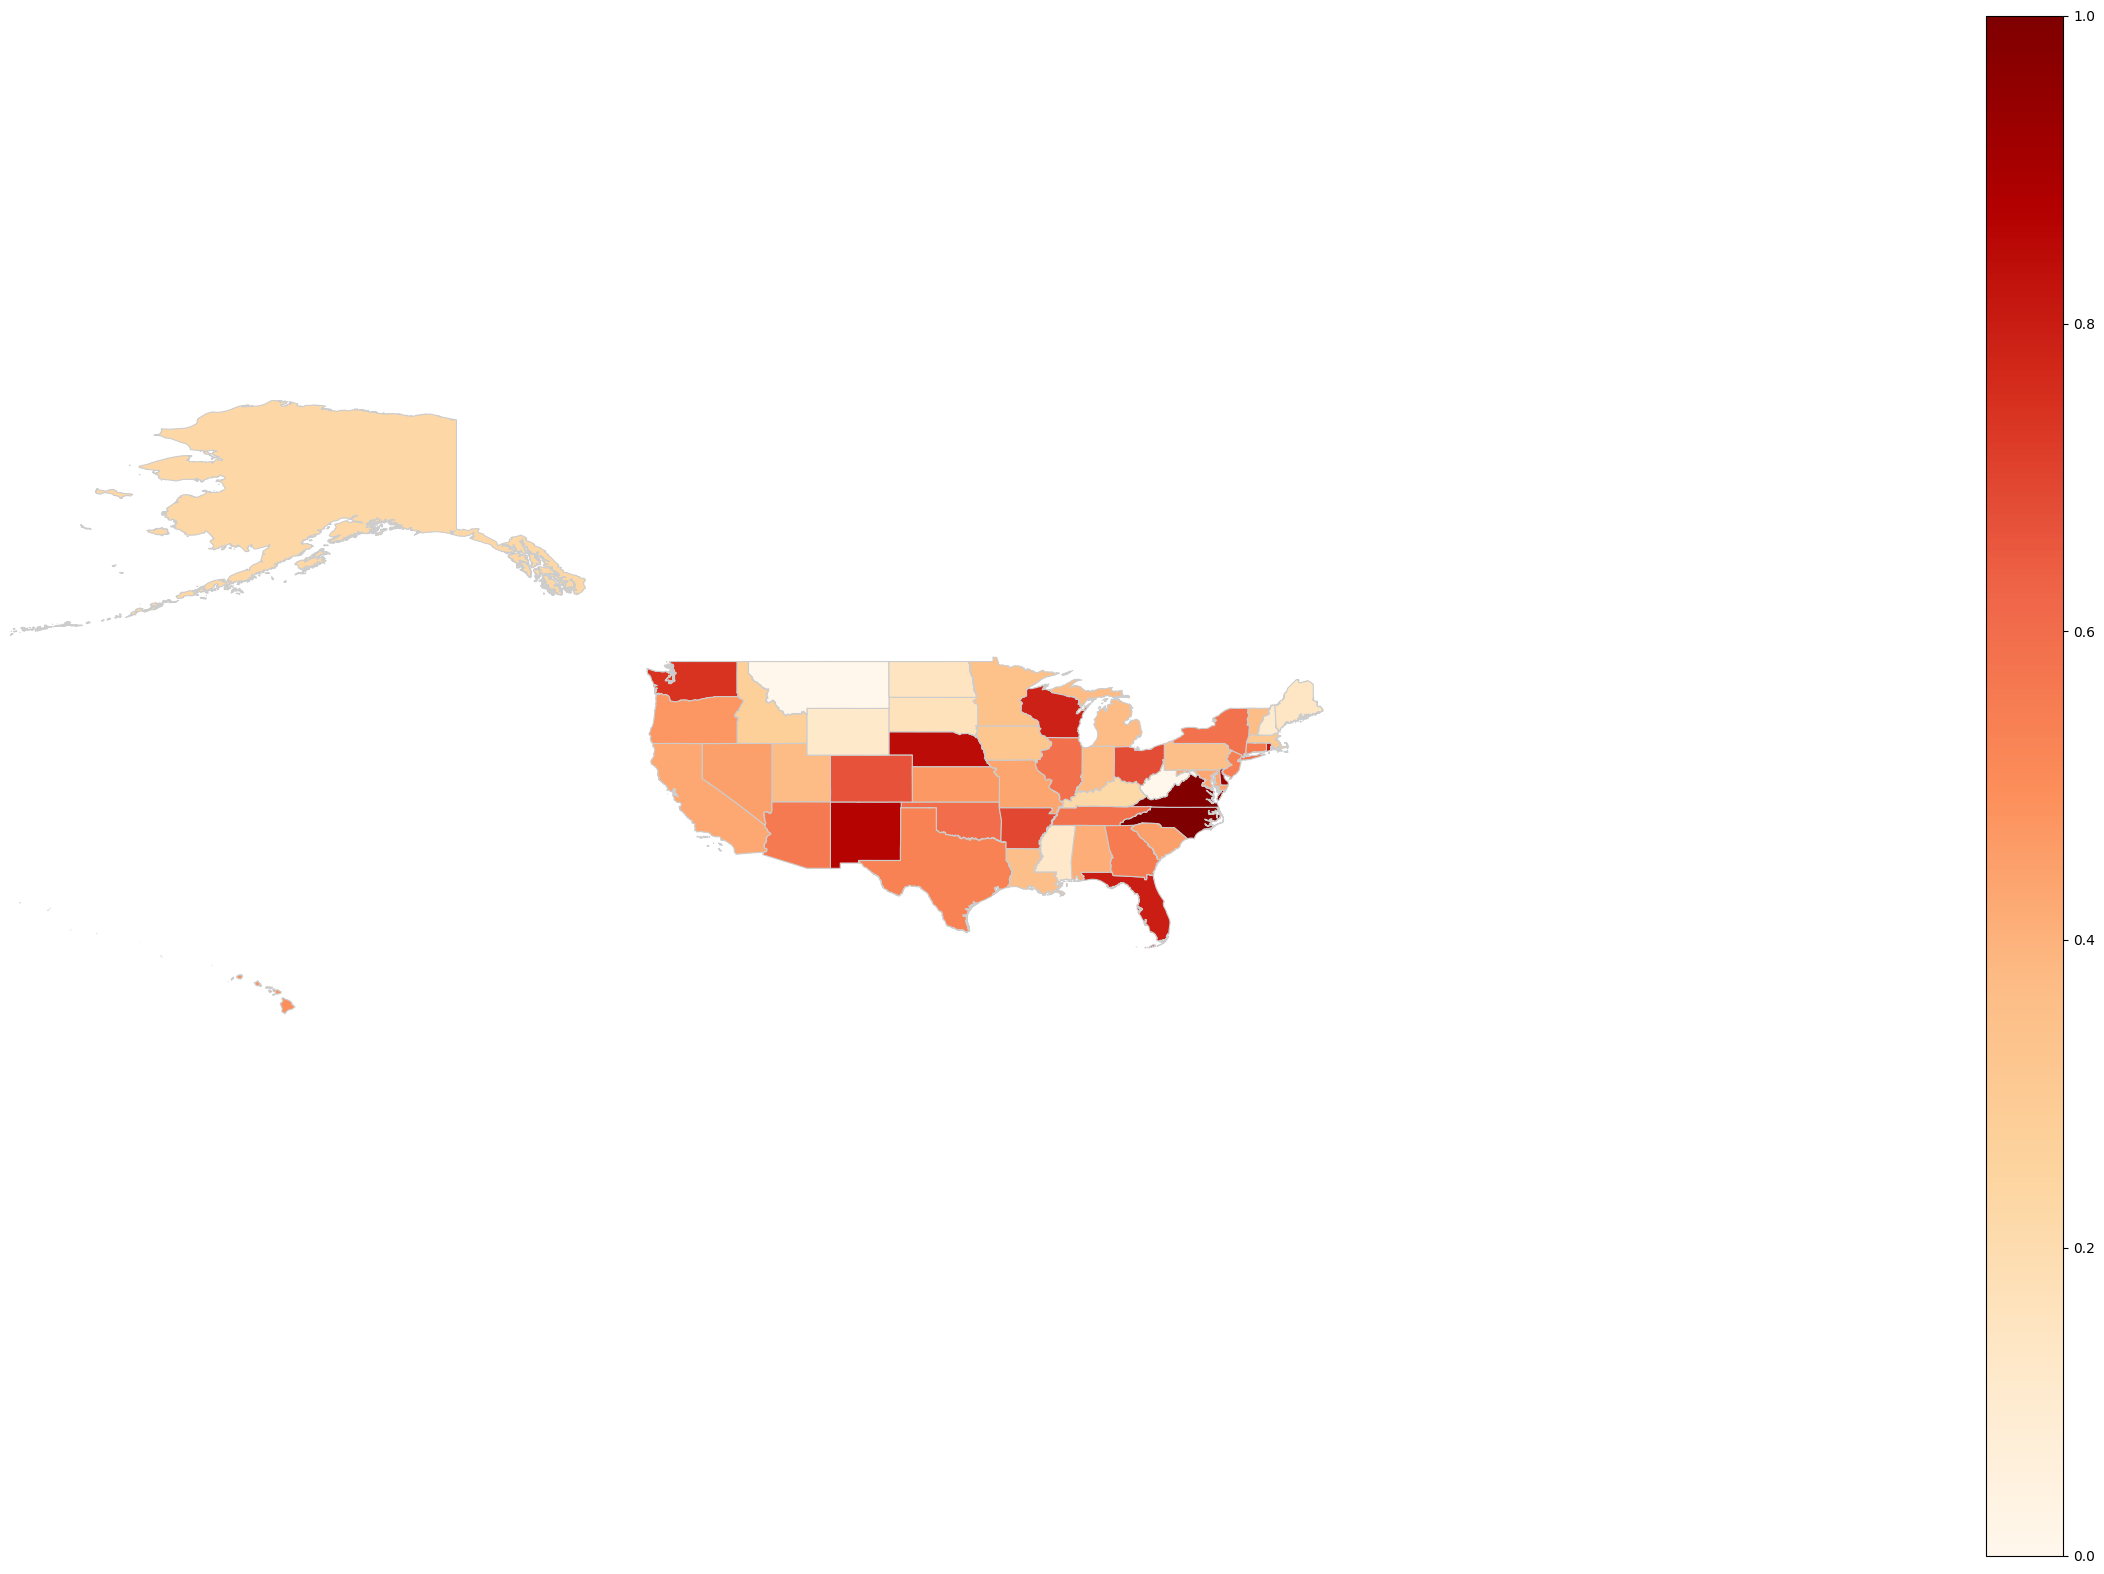

In [35]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

for i in range(lda.num_topics):
    topic_id = i  # Replace with your specific topic ID
    state_intensity = {state: distribution[topic_id] for state, distribution in state_topic_distributions.items()}

    # Load the shapefile using Geopandas
    shapefile_path = "cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    gdf = gpd.read_file(shapefile_path)

    # Ensure that the GeoDataFrame has a column with state abbreviations that match your distribution keys
    gdf['state_abbr'] = gdf['STUSPS']  # Replace 'STUSPS' with the actual column name for state abbreviations if different

    # Convert the dictionary to a DataFrame
    intensity_df = pd.DataFrame(list([(i[0], i[1][1]) for i in state_intensity.items()]), columns=['index', 'intensity'])

    # Merge the DataFrame with the GeoDataFrame
    gdf = gdf.merge(intensity_df, how='left', left_on='state_abbr', right_on='index')

    # Set the size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))

    # Plot the GeoDataFrame with intensity coloring
    gdf.plot(column='intensity', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

    # Remove the axis
    ax.axis('off')

    # Set the aspect of the plot to equal and adjust the limits if needed
    ax.set_aspect('equal')
    ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2] - 200])  # set x limits to the bounds of the shapes
    ax.set_ylim([gdf.total_bounds[1] + 20, gdf.total_bounds[3]])  # set y limits to the bounds of the shapes

    # Add a colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd'), ax=ax)

    # Show the plot
    plt.show()


In [19]:
import pandas as pd

topic_names = ["top_" + str(i) for i in range(lda.num_topics)]
# Convert the topic distributions into a DataFrame
topic_dist_df = pd.DataFrame({
    state: {topic_id: prob for topic_id, prob in distribution}
    for state, distribution in state_topic_distributions.items()
}).T.fillna(0)  # Transpose and fill missing values with 0

# Set the index of the DataFrame to be the states
topic_dist_df.index.rename('state', inplace=True)

# Rename the remaining columns according to topic_names
topic_dist_df.columns = topic_names

# Save to CSV
print(topic_dist_df.head())
topic_dist_df.to_csv('topic_distributions.csv')


          top_0     top_1     top_2     top_3
state                                        
ID     0.132913  0.291661  0.417711  0.157716
DC     0.178445  0.210791  0.286268  0.324496
KY     0.188915  0.264646  0.303196  0.243243
DE     0.158665  0.258087  0.362362  0.220887
FL     0.308289  0.258679  0.217661  0.215370


In [62]:
file_path = 'combined_data.csv'
combined_df = pd.read_csv(file_path)
# columns_to_select = ['state', 'bg', 'pi', 'pl', 'White alone', 'Black or African American alone']
# combined_df = combined_df[columns_to_select]
# print(combined_df)
# columns_to_select = ['state', 'White alone']
# combined_df = combined_df[columns_to_select]
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

In [63]:
print(combined_df)

   state  bg    pl        gdp  Hispanic or Latino  White alone  \
0     AL  77 -29.6   222081.4            5.255421    63.120519   
1     AK  41 -14.6    50344.6            6.793648    57.507932   
2     AZ  51  -7.6   362603.5           30.654442    53.367069   
3     AR  70 -31.8   128061.2            8.528805    68.521785   
4     CA  47  25.5  2925146.9           39.404027    34.686908   
5     CO  47   6.4   380921.9           21.881756    65.134210   
6     CT  42  12.1   258625.0           17.285155    63.207637   
7     DE  46  13.7    72550.3           10.534897    58.573885   
8     DC  50  68.2   137762.3           11.261339    37.962860   
9     FL  53  -7.6  1068377.5           26.451809    51.538707   
10    GA  64  -7.4   602321.8           10.487926    50.057898   
11    HI  44  31.6    79592.5            9.546194    21.601818   
12    ID  51 -37.0    82818.6           13.017575    78.871093   
13    IL  50  13.4   810210.1           18.243189    58.323874   
14    IN  

In [64]:
print(features)

[[ 7.70000000e+01 -2.96000000e+01  2.22081400e+05  5.25542073e+00
   6.31205194e+01  2.56386837e+01  4.60145625e-01  1.51102278e+00
   5.19875588e-02  2.87702972e-01]
 [ 4.10000000e+01 -1.46000000e+01  5.03446000e+04  6.79364759e+00
   5.75079323e+01  2.82673226e+00  1.48403785e+01  5.92439776e+00
   1.69827554e+00  6.23814582e-01]
 [ 5.10000000e+01 -7.60000000e+00  3.62603500e+05  3.06544415e+01
   5.33670689e+01  4.43488655e+00  3.69055340e+00  3.47950682e+00
   2.00279606e-01  4.42019033e-01]
 [ 7.00000000e+01 -3.18000000e+01  1.28061200e+05  8.52880468e+00
   6.85217850e+01  1.49387486e+01  6.82345550e-01  1.70046794e+00
   4.74178522e-01  2.67206903e-01]
 [ 4.70000000e+01  2.55000000e+01  2.92514690e+06  3.94040268e+01
   3.46869079e+01  5.36009421e+00  3.94769891e-01  1.51215572e+01
   3.49451719e-01  5.66360810e-01]
 [ 4.70000000e+01  6.40000000e+00  3.80921900e+05  2.18817558e+01
   6.51342100e+01  3.83306135e+00  5.84857511e-01  3.38118584e+00
   1.55965467e-01  5.11975481e-01

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np

# Assuming you have already created and populated the `state_topic_distributions` dictionary
# and you have the `combined_df` DataFrame with state-related columns as features

# Choose the topic you want to use as labels
chosen_topic =2  # Replace with the index of the desired topic

# Create a mapping of state names to topic distributions
state_topic_mapping = {}
for state, distribution in state_topic_distributions.items():
    state_topic_mapping[state] = distribution[chosen_topic][1]  # [1] retrieves the probability for the chosen topic

# Extract the aligned topic proportions as labels based on `combined_df` order
labels = [state_topic_mapping[state] for state in combined_df["state"]]
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features to normalize them
features_normalized = scaler.fit_transform(features)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the normalized features
model.fit(features_normalized, labels)

# Get the coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Make predictions using the model
predictions = model.predict(features_normalized)

# Calculate R-squared
r_squared = r2_score(labels, predictions)

print("R-squared:", r_squared)

# Print coefficients and feature names
feature_names = combined_df.columns[1:]  # Exclude the "State" column
for feature_name, coefficient in zip(feature_names, coefficients):
    print(f"{feature_name}: {coefficient}")


NameError: name 'state_topic_distributions' is not defined

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data into training and test sets (80% train, 20% test)
features_train, features_test, labels_train, labels_test = train_test_split(
    features_normalized, labels, test_size=0.2, random_state=42
)

# Fit the model with the training data
model.fit(features_train, labels_train)

# Predict on the training set and calculate R-squared
predictions_train = model.predict(features_train)
r_squared_train = r2_score(labels_train, predictions_train)
print("Training R-squared:", r_squared_train)

# Predict on the test set
predictions_test = model.predict(features_test)

# Calculate R-squared for the test set
r_squared_test = r2_score(labels_test, predictions_test)
print("Test R-squared:", r_squared_test)

# Calculate Mean Squared Error for the test set
mse_test = mean_squared_error(labels_test, predictions_test)
print("Test Mean Squared Error:", mse_test)

# Print coefficients and feature names
for feature_name, coefficient in zip(feature_names, model.coef_):
    print(f"{feature_name}: {coefficient}")


Training R-squared: 0.7390416683680767
Test R-squared: 0.8982252757400919
Test Mean Squared Error: 0.0015445283975823987
bg: 0.014940110296899123
pl: 0.028315245069918272
gdp: -0.008688876712996856
Hispanic or Latino: 0.03995838090115168
White alone: -0.06580798809254507
Black or African American alone: -0.037817203036047284
American Indian and Alaska Native alone: 0.0038052012009383712
Asian alone: -0.005034153675714179
Native Hawaiian and Other Pacific Islander alone: -0.03193152444343303
Some Other Race alone: -0.012625823955906253


Mean Squared Error: 0.0016380746730267337


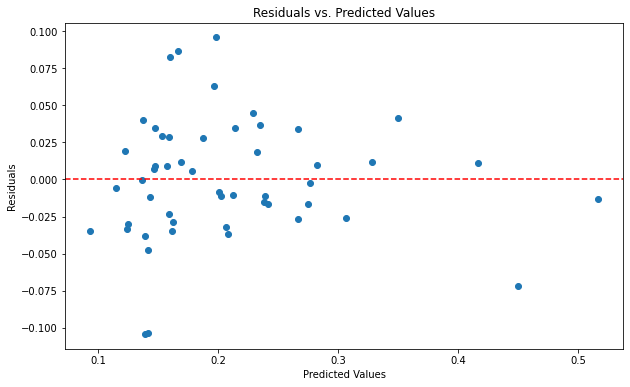


Feature Importances:
bg: 0.004896528791092363
pl: 0.0220718674072313
gdp: 0.0028648920307049294
Hispanic or Latino: 0.008046124273473097
White alone: -0.11088081954759432
Black or African American alone: -0.06483462970166629
American Indian and Alaska Native alone: -0.008126802205393075
Asian alone: -0.03707135185050358
Native Hawaiian and Other Pacific Islander alone: -0.026297139739538674
Some Other Race alone: -0.008845525577648101

Feature Importances by Magnitude:
White alone: 0.11088081954759432
Black or African American alone: 0.06483462970166629
Asian alone: 0.03707135185050358
Native Hawaiian and Other Pacific Islander alone: 0.026297139739538674
pl: 0.0220718674072313
Some Other Race alone: 0.008845525577648101
American Indian and Alaska Native alone: 0.008126802205393075
Hispanic or Latino: 0.008046124273473097
bg: 0.004896528791092363
gdp: 0.0028648920307049294


In [67]:
from sklearn.metrics import mean_squared_error

# Calculate and print the Mean Squared Error
mse = mean_squared_error(labels, predictions)
print("Mean Squared Error:", mse)


import matplotlib.pyplot as plt

# Assuming you have 'predictions' from your model and 'labels' as the actual values
# Calculate residuals
residuals = labels - predictions

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Line at 0 to indicate no residual
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()
# Print the coefficients as a measure of feature importance

print("\nFeature Importances:")
for feature_name, coefficient in zip(feature_names, coefficients):
    print(f"{feature_name}: {coefficient}")

# Additionally, you can calculate the absolute values of the coefficients to see the magnitude of feature importance
print("\nFeature Importances by Magnitude:")
for feature_name, coefficient in sorted(zip(feature_names, np.abs(coefficients)), key=lambda x: x[1], reverse=True):
    print(f"{feature_name}: {coefficient}")


In [54]:
import matplotlib.pyplot as plt

# Assuming you have the `combined_df` DataFrame with state-related columns as features

# Choose the two columns you want to plot
column1 = "hs"  # Replace with the name of the first column
column2 = "fi"  # Replace with the name of the second column

# Extract the data from the chosen columns
data1 = combined_df[column1].values
data2 = combined_df[column2].values

# Create a scatter plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(data1, data2, alpha=0.5)
plt.title(f'{column1} vs. {column2}')
plt.xlabel(column1)
plt.ylabel(column2)
plt.grid(True)
plt.show()


KeyError: 'hs'

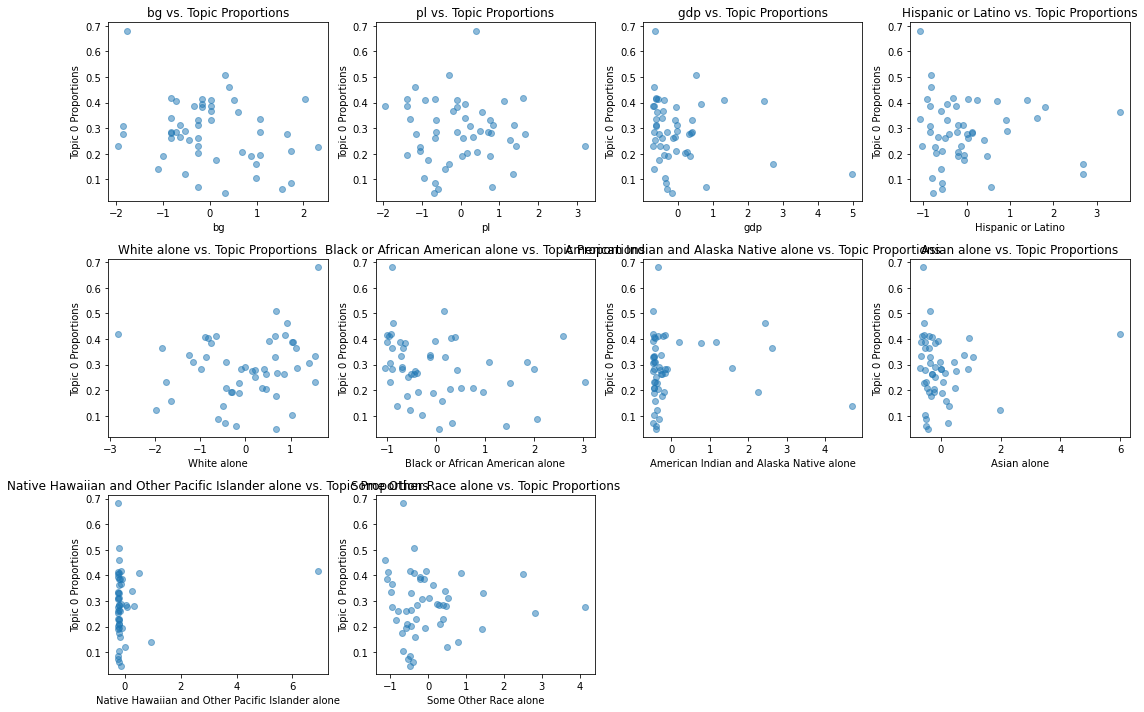

In [68]:
import matplotlib.pyplot as plt

# Assuming you have already created and populated the `state_topic_distributions` dictionary
# and you have the `combined_df` DataFrame with state-related columns as features

# Choose the topic you want to use as labels
chosen_topic = 0 # Replace with the index of the desired topic

# Extract the chosen topic proportions as labels
labels = []
for state, distribution in state_topic_distributions.items():
    labels.append(distribution[chosen_topic][1])  # [1] retrieves the probability for the chosen topic

# Convert labels and features to NumPy arrays
labels = np.array(labels)
features = combined_df.drop("state", axis=1).values  # Assuming "State" is the state column

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the features to normalize them
features_normalized = scaler.fit_transform(features)

# Create scatter plots for each feature against the labels
feature_names = combined_df.columns[1:]  # Exclude the "State" column

plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

for i, feature_name in enumerate(feature_names):
    plt.subplot(3, 4, i + 1)  # Adjust the subplot grid as needed
    plt.scatter(features_normalized[:, i], labels, alpha=0.5)
    plt.title(f'{feature_name} vs. Topic Proportions')
    plt.xlabel(feature_name)
    plt.ylabel(f'Topic {chosen_topic} Proportions')

plt.tight_layout()
plt.show()


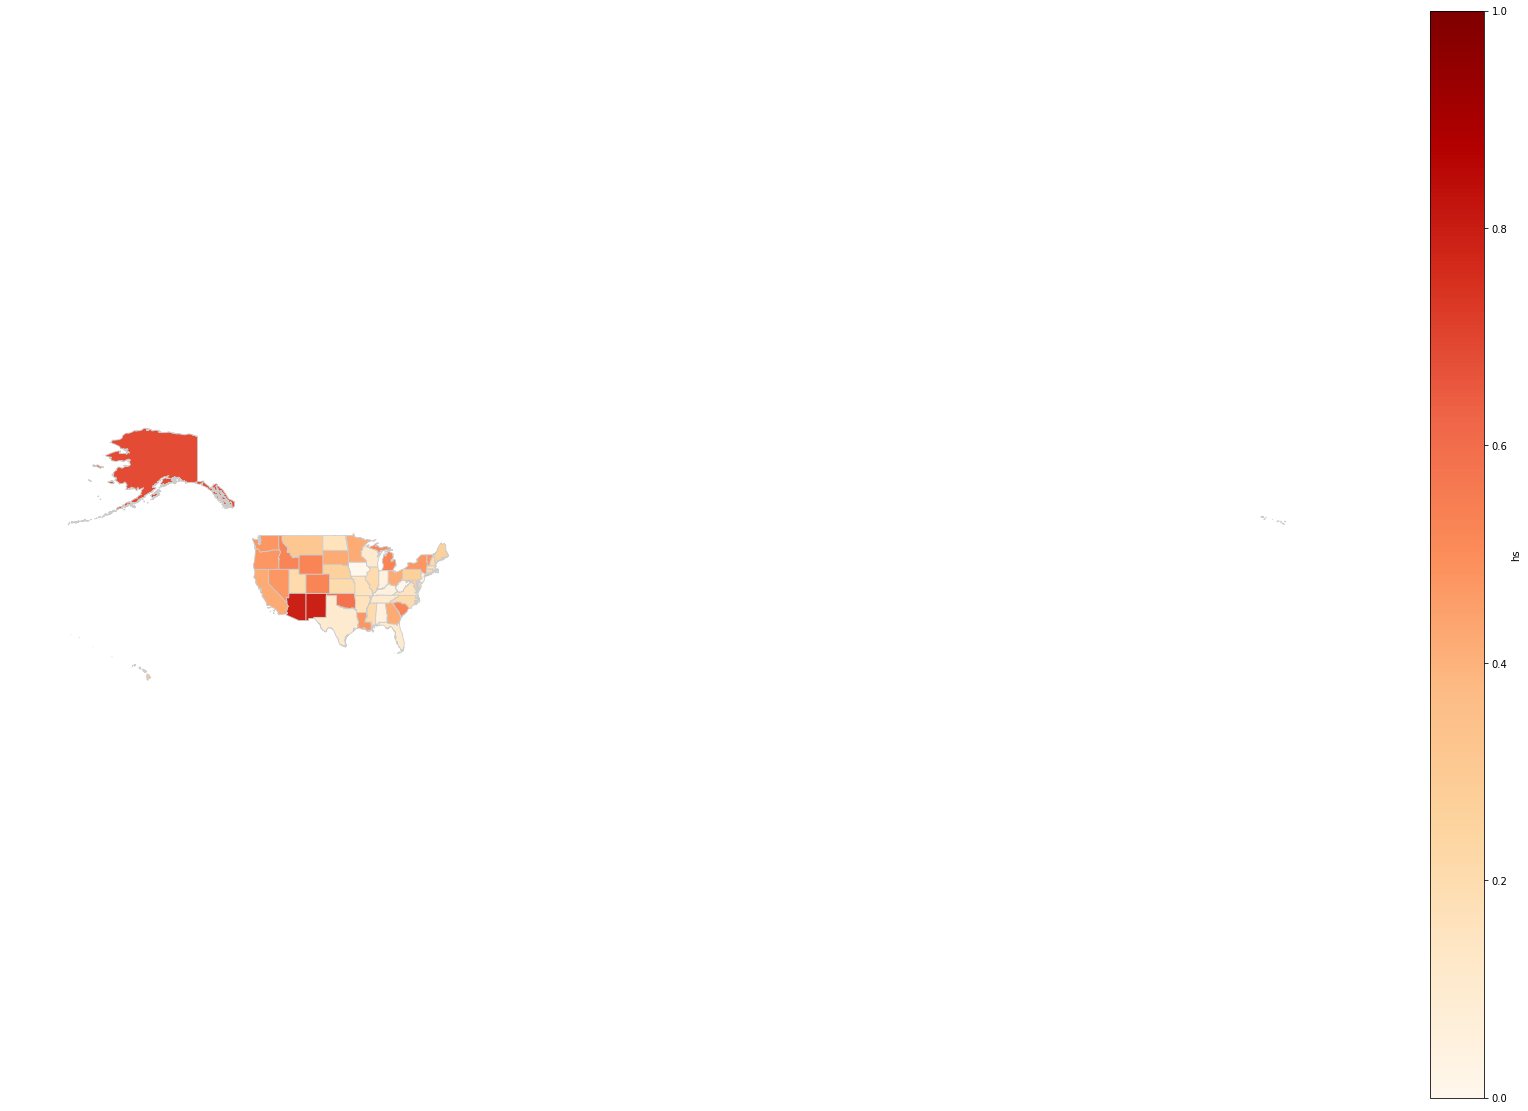

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to plot a specific feature
def plot_feature_on_map(feature_name):
    # Extract the feature values for the specified column
    feature_values = combined_df[feature_name]

    # Load the shapefile using Geopandas
    shapefile_path = "/Users/hanmingyang/Downloads/cb_2018_us_state_500k/cb_2018_us_state_500k.shp"
    gdf = gpd.read_file(shapefile_path)

    # Ensure that the GeoDataFrame has a column with state abbreviations that match your distribution keys
    gdf['state_abbr'] = gdf['STUSPS']  # Replace 'STUSPS' with the actual column name for state abbreviations if different

    # Merge the DataFrame with the GeoDataFrame
    gdf = gdf.merge(combined_df[['state', feature_name]], left_on='state_abbr', right_on='state')

    # Set the size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(30, 20))

    # Plot the GeoDataFrame with feature values coloring
    gdf.plot(column=feature_name, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')

    # Remove the axis
    ax.axis('off')

    # # Set the aspect of the plot to equal and adjust the limits if needed
    # ax.set_aspect('equal')
    # ax.set_xlim([gdf.total_bounds[0], gdf.total_bounds[2] - 200])  # set x limits to the bounds of the shapes
    # ax.set_ylim([gdf.total_bounds[1] + 20, gdf.total_bounds[3]])  # set y limits to the bounds of the shapes


    # Add a colorbar
    fig.colorbar(plt.cm.ScalarMappable(cmap='OrRd'), ax=ax, label=feature_name)

    # Show the plot
    plt.show()

# Specify the desired feature name to plot
desired_feature_name = "hs"  # Replace with the desired feature name

# Call the function to plot the selected feature values on the map
plot_feature_on_map(desired_feature_name)


## CSV Processing

In [92]:
import pandas as pd

# Replace 'file_path' with the actual path of your CSV file
file_path = 'combined_data.csv'
data = pd.read_csv(file_path)
print(data.shape)
# Display the first few rows of the DataFrame
print(data.head())


(51, 11)
  state    hs     fi        pv  bg  White alone  \
0    AL  0.09  62400    849624  77    66.248048   
1    AK  0.21  83700    153778  41    63.109045   
2    AZ  0.23  70200   1672143  51    64.044088   
3    AR  0.11  57300    423932  70    72.804552   
4    CA  0.16  85300  11110250  47    43.610365   

   Black or African American alone  American Indian and Alaska Native alone  \
0                        25.062073                                 0.626780   
1                         3.122185                                13.847217   
2                         4.468316                                 4.088866   
3                        14.423686                                 0.871956   
4                         5.702021                                 1.542779   

   Asian alone  Native Hawaiian and Other Pacific Islander alone  \
0     1.544688                                          0.053993   
1     6.252313                                          1.488981   
2    

In [87]:
# Let's create a dictionary of state names to their abbreviations
state_abbreviations = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA',
    'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO',
    'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ',
    'New Mexico': 'NM', 'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH',
    'Oklahoma': 'OK', 'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT',
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY', "District of Columbia": "DC"
}

# Now, let's replace the state names with their abbreviations
data['X.1'] = data['X.1'].map(state_abbreviations)

columns_to_select = ['X.1', 'X.2']
highschool_df = data[columns_to_select]


In [88]:
highschool_df = highschool_df.rename(columns={'X.1': 'state', 'X.2': 'hs'})

# Check if there are any zeros in the 'high_school_graduation_rate' column
any_zeros = (highschool_df['hs'] == 0).any()
any_nans = highschool_df['state'].isna().any()

print(highschool_df)
print(any_zeros, any_nans)

   state  hs
0     KY  94
1     IA  94
2     TX  94
3     CT  93
4     MA  93
5     ND  93
6     WI  93
7     VA  93
8     WV  93
9     MO  92
10    NE  92
11    NJ  92
12    FL  92
13    AL  91
14    KS  91
15    NC  90
16    TN  90
17    SD  90
18    OH  90
19    UT  90
20    PA  90
21    MI  89
22    IN  89
23    NH  88
24    MT  88
25    AR  88
26    MS  88
27    RI  87
28    OK  87
29    IL  87
30    ID  87
31    NV  87
32    GA  87
33    WA  87
34    DE  86
35    HI  86
36    CA  86
37    SC  86
38    ME  85
39    NY  85
40    OR  84
41    MD  83
42    LA  83
43    CO  83
44    WY  82
45    AK  81
46    VT  81
47    NM  78
48    DC  77
49    AZ  74
50    MN  87
False False


In [89]:
# Replace 'file_path' with the actual path of your CSV file
file_path = 'social_data/personalincome_edited.csv'
data = pd.read_csv(file_path)

data.columns = ['x', 'state', 'pi']

columns_to_select = ['state', 'pi']
income_df = data[columns_to_select]
income_df['state'] = income_df['state'].map(state_abbreviations)


any_zeros = (income_df['pi'] == 0).any()
any_nans = income_df['state'].isna().any()
print(any_zeros, any_nans)
print(income_df.shape)
# Display the first few rows of the DataFrame
print(income_df)

False False
(51, 2)
   state     pi
0     AL  45887
1     AK  61898
2     AZ  52133
3     AR  47147
4     CA  70061
5     CO  64852
6     CT  77383
7     DE  55778
8     DC  89703
9     FL  56561
10    GA  51469
11    HI  57036
12    ID  49691
13    IL  61587
14    IN  51719
15    IA  52586
16    KS  55041
17    KY  47026
18    LA  50243
19    ME  54301
20    MD  64825
21    MA  77393
22    MI  52786
23    MN  61278
24    MS  42513
25    MO  52095
26    MT  53546
27    NE  56733
28    NV  54650
29    NH  67883
30    NJ  70957
31    NM  46631
32    NY  69873
33    NC  51781
34    ND  61091
35    OH  52879
36    OK  50249
37    OR  56507
38    PA  60320
39    RI  59066
40    SC  48772
41    SD  59465
42    TN  51928
43    TX  55118
44    UT  51751
45    VT  57978
46    VA  61474
47    WA  67674
48    WV  45071
49    WI  55431
50    WY  65558


/var/folders/58/583pvq8x6jx63x2fj8bzhg6c0000gn/T/ipykernel_98301/1966128008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_df['state'] = income_df['state'].map(state_abbreviations)


In [91]:
# Replace 'file_path' with the actual path of your CSV file
file_path = 'social_data/president.csv'
data = pd.read_csv(file_path)
print(data)

      year    state state_po  state_fips  state_cen  state_ic        office  \
0     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
1     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
2     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
3     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
4     1976  ALABAMA       AL           1         63        41  US PRESIDENT   
...    ...      ...      ...         ...        ...       ...           ...   
4282  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4283  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4284  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4285  2020  WYOMING       WY          56         83        68  US PRESIDENT   
4286  2020  WYOMING       WY          56         83        68  US PRESIDENT   

                    candidate              party_de

In [85]:
import collections
print(set(state_abbreviations.values()) == set(states))
print(collections.Counter(highschool_df['state'].tolist()))# == set(income_df['state'].tolist())

True
Counter({'ME': 2, 'KY': 1, 'IA': 1, 'TX': 1, 'CT': 1, 'MA': 1, 'ND': 1, 'WI': 1, 'VA': 1, 'WV': 1, 'MO': 1, 'NE': 1, 'NJ': 1, 'FL': 1, 'AL': 1, 'KS': 1, 'NC': 1, 'TN': 1, 'SD': 1, 'OH': 1, 'UT': 1, 'PA': 1, 'MI': 1, 'IN': 1, 'NH': 1, 'MT': 1, 'AR': 1, 'MS': 1, 'RI': 1, 'OK': 1, 'IL': 1, 'ID': 1, 'NV': 1, 'GA': 1, 'WA': 1, 'DE': 1, 'HI': 1, 'CA': 1, 'SC': 1, 'NY': 1, 'OR': 1, 'MD': 1, 'LA': 1, 'CO': 1, 'WY': 1, 'AK': 1, 'VT': 1, 'NM': 1, 'DC': 1, 'AZ': 1, 'MN': 1})
